In [1]:
import pandas as pd
import requests
from io import StringIO
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
from scipy.stats import norm
import pandas_market_calendars as mcal
from time import strptime
import pickle
import seaborn as sns
from matplotlib.pyplot import figure


In [14]:
class RiskNeutralDensity:
    def __init__(self, date, option_type='call', verbose = False):
        self.verbose = verbose
        self.date = date
        self.df = None
        self.maturity_str=None
        self.maturity_date = None
        self.pmf = None
        self.T = None
        self.rf_df = None
        self.rf = None
        self.S0 = None
        self.est_pts = None
        self.original_option_df = None
        self.call_option_df = None
        self.put_option_df = None
        self.original_strikes = None
        self.fitted_models= dict()
        self.call_payoff_matrix = None
        self.put_payoff_matrix = None
        self.year = None
        self.month = None
        self.day = None
        self.evaluation_steps = None
        self.moment_df = None
        self.error_df = None
        self.n = None
        self.forward_price = None
        
        if option_type.lower() == 'call' or option_type.lower() == 'c':
            self.option_type = 'C'
        else:
            self.option_type='P'
        self.download_data()

    def download_data(self):
        url = 'https://www.hkex.com.hk/eng/stat/dmstat/dayrpt/hsio{}.htm'
        date = self.date[2:]
        url = url.format(date)
        html = requests.get(url).content
        if 'This page will be redirected to the homepage after five seconds' in str(html):
            return
        soup = BeautifulSoup(html, 'html5lib')
        result = soup.findAll(text=True)
        new_l = list()
        for table in result[6:-2]:
            for i in table.split('\n'):
                if (len(i)==0) or (i.isspace()) or ('CONTRACT STRIKE' in i) or ('MONTH' in i) or ('TOTAL' in i) or ('MONTH PUT/CALL' in i) or ('CONTRACT STRIKE' in i):
                    continue
                i = i.replace('|', '')
                new_l.append(i)
        headers='  '.join(['maturity','strike','type', 'AHOpen', 'AHHigh', 'AHLow', 'AHClose', 'AHVolume',
                           'Open', 'High', 'Low', 'Close', 'Chg','IV%', 'Volume',
                           'CombHigh', 'CombLow', 'CombVolume', 'OI', 'ChgOI'])
        new_l = [headers] + new_l
        CSV_IO = StringIO('\n'.join(new_l))
        df = pd.read_csv(CSV_IO, delimiter=r"\s+")
        df.strike = df.strike.astype(float).astype(int)
        self.df = df

    def select_maturity(self, ascending_order, evaluation_steps=5, min_hsi = 5, max_hsi = 100000):
        self.evaluation_steps = evaluation_steps
        self.maturity_str = self.df.maturity.unique()[ascending_order]
        self.cal_butterfly_spread()
        if self.option_type == 'C':
            self.S0 = (self.original_option_df['Close'] + self.original_option_df.index).iloc[0]
        else:
            self.S0 = (self.original_option_df['Close'] + self.original_option_df.index).iloc[-1]
        self.get_T()
        self.get_rf()
        self.est_pts = np.array(list(range(min_hsi, max_hsi, evaluation_steps)))

        self.create_payoff_matirx()
        self.fit_rn_histogram(plot=False)
        self.forward_price =  self.S0 * np.exp(self.rf * self.T)
        
    def get_df(self, maturity_str, option_type):
        df = self.df
        option_df =df.loc[(df.maturity==self.maturity_str) & (df.type==option_type)][['strike','IV%', 'Close']].copy()
        return option_df
    
    def cal_butterfly_spread(self):
        df = self.df
        
        call_option_df = self.get_df(self.maturity_str, 'C')
        put_option_df = self.get_df(self.maturity_str, 'P')
        self.original_strikes = call_option_df.strike
    
        if self.option_type == 'C':
            option_df = call_option_df.copy()
        else:
            option_df = put_option_df.copy()
            
        k = option_df['strike']
        price = option_df['Close']
        gap_chg = k.diff().diff().fillna(0)
        idx_gap_chg = gap_chg.loc[gap_chg != 0.0].index
        pmf = (-2 * price + price.shift(1) + price.shift(-1))
        for i in idx_gap_chg:
            pmf.loc[i - 1] = 0
        pmf = pmf / k.diff().fillna(1)
        pmf.index = option_df.strike

        self.call_option_df = call_option_df.set_index('strike')
        self.put_option_df = put_option_df.set_index('strike')
        
        if self.option_type == 'C':
            self.original_option_df = self.call_option_df.copy()
        else:
            self.original_option_df = self.put_option_df.copy()
        
        self.pmf = pd.DataFrame({'pmf': pmf}, index=pmf.index).fillna(0)
        self.n = self.call_option_df.shape[0] + self.put_option_df.shape[0]

    def gaussian_kernel(self, x):
        return np.exp(-np.power(x,2)/2)/np.sqrt(2*np.pi)

    def kernel_regression(self, x, y, est_pts, wb=200):
        kernel=self.gaussian_kernel
        res = list()
        for et_pt in est_pts:
            distance = x-et_pt
            kernel_wgts = kernel(distance/wb)
            sum_ = np.sum(kernel_wgts)
            if sum_ == 0.0:
                res.append(np.nan)
            else:
                res.append(np.dot(kernel_wgts, y) / sum_)
        return pd.DataFrame({'x': est_pts, 'y': res}).set_index('x')
    
    def bs_call(self, S, K, T, r, vol):
        N = norm.cdf
        d1 = (np.log(S/K) + (r + 0.5*vol**2)*T) / (vol*np.sqrt(T))
        d2 = d1 - vol * np.sqrt(T)
        return S * norm.cdf(d1) - np.exp(-r * T) * K * norm.cdf(d2)

    def bs_put(self, S, K, T, r, vol):
        N = norm.cdf
        d1 = (np.log(S/K) + (r + 0.5*vol**2)*T) / (vol*np.sqrt(T))
        d2 = d1 - vol * np.sqrt(T)
        return np.exp(-r * T) * K * norm.cdf(-d2) - S * norm.cdf(-d1)

    def get_T(self):
        year = int(self.date[:4])
        month = int(self.date[4:6])
        day = int(self.date[6:8])
        current_time = f'{year}-{str(100+month)[-2:]}-{day}'
        month_last_day = {1: 31, 2: 28, 3: 31, 4: 30, 5: 31, 6: 30, 7: 31, 8: 31, 9:30, 10:31, 11:30, 12:31}

        mat = self.maturity_str
        mat_month = str(strptime(mat.split('-')[0],'%b').tm_mon + 100)[-2:]
        mat_year = '20'+str(int(mat.split('-')[1])+100)[-2:]
        mat_month_last_bday = month_last_day[int(mat_month)]

        last_bday = f'{mat_year}-{mat_month}-{str(mat_month_last_bday+100)[-2:]}'

        hkex = mcal.get_calendar('HKEX')
        calendar_result = hkex.schedule(start_date=current_time, end_date=last_bday).index
        mat_day = str(calendar_result[-1].day +100)[-2:]

        self.maturity_date =f'{mat_year}-{mat_month}-{mat_day}'

        self.T =  (calendar_result.shape[0]-1) / 251

        assert self.T > 0, "T must be greater than 0!"

        self.year = year
        self.month = month
        self.day = day
        return self.T

    def get_rf(self):
        if self.rf_df is None:
            self.download_hibor_rate()
        self.rf = self.rf_df.iloc[-1]['HIBOR']
        return self.rf

    def download_hibor_rate(self):
        year = self.year
        month = self.month
        day = self.day
        r = requests.get(f'http://www.hkab.org.hk/hibor/listRates.do?lang=en&Submit=Search&year={year}&month={month}&day={day}')
        soup = BeautifulSoup(r.content, 'html5lib')
        result = soup.findAll('td', text=True)
        time_map = {'Overnight': 1/360, '1 Week': 5/251, '2 Weeks':10/254,
                    '1 Month': 21/251, '2 Months': 42/254, '3 Months':63/254, '6 Months':21/251*6, '12 Months':1}
        tmp = dict()
        mat = None
        flag = False
        for item in result:
            if item.text in ['Overnight', '1 Week', '2 Weeks', '1 Month', '2 Months', '3 Months', '6 Months', '12 Months']:
                mat = item.text
                flag = True
                continue
            if flag:
                flag=False
                tmp[time_map[mat]] = float(item.text)
        self.rf_df = ((pd.DataFrame(tmp, index=['HIBOR']).T)/100).reset_index()

    def create_payoff_matirx(self):
        est_pts = self.est_pts

        call_payoff_matrix = list()
        put_payoff_matrix = list()

        for k in self.call_option_df.index.values:
            call_payoff_matrix.append(np.clip(est_pts - k, a_min=0, a_max=None))
            
        for k in self.put_option_df.index.values:
            put_payoff_matrix.append(np.clip(k-est_pts, a_min=0, a_max=None))
            
        self.call_payoff_matrix = np.array(call_payoff_matrix)
        self.put_payoff_matrix = np.array(put_payoff_matrix)
        
    def predict_price(self, density, payoff_matrix, lower_clip=1):
        return np.nan_to_num(
            np.clip(
                np.array(
                    np.dot(payoff_matrix, density) * np.exp(-self.rf * self.T)).reshape(-1), a_min=lower_clip, a_max=None))

    def mean_squared_error(self, density):
        call_option_prices = self.call_option_df['Close']
        put_option_prices = self.put_option_df['Close']
        
        
        call_est_err = self.predict_price(density, self.call_payoff_matrix) - call_option_prices
        put_est_err = self.predict_price(density, self.put_payoff_matrix) - put_option_prices
        
        sum_ = np.power(call_est_err, 2).sum() + np.power(put_est_err, 2).sum()

        mean_dif = np.dot(self.est_pts, density) - self.S0* np.exp(self.rf * self.T)
        n = self.n
        return sum_ /n
    
#     def mean_squared_error(self, density):
#         call_option_prices = self.call_option_df['Close']
#         put_option_prices = self.put_option_df['Close']
        
        
#         call_est_err = self.predict_price(density, self.call_payoff_matrix) - call_option_prices
#         put_est_err = self.predict_price(density, self.put_payoff_matrix) - put_option_prices
        
#         sum_ = np.power(call_est_err, 2).sum() + np.power(put_est_err, 2).sum()

#         mean_dif = np.dot(self.est_pts, density) - self.S0* np.exp(self.rf * self.T)
#         n = self.n
#         return sum_ /n
    
    def mean_abs_error(self, density, multiplier=5):
        call_option_prices = self.call_option_df['Close']
        put_option_prices = self.put_option_df['Close']
        
        call_est_err = self.predict_price(density, self.call_payoff_matrix) -call_option_prices
        put_est_err = self.predict_price(density, self.put_payoff_matrix) - put_option_prices
        
        idx = call_option_prices.loc[call_option_prices>1].shape[0]
        call_est_err = call_est_err.iloc[:idx+1]
        idx = put_option_prices.loc[put_option_prices>1].shape[0]
        put_est_err = put_est_err.iloc[:idx+1]
        
#         sum_ = ((np.power(call_est_err, 2)+ np.power(put_est_err, 2)).values* moneyness).sum()
        sum_ = ((np.abs(call_est_err)+ np.abs(put_est_err))).sum()
        n = self.n
        return sum_ /n
    
#     def mean_weighted_squared_pct_error(self, density, multiplier=5):
#         call_option_prices = self.call_option_df['Close']
#         put_option_prices = self.put_option_df['Close']
#         moneyness = (self.original_strikes / self.S0-1)*multiplier
# #         moneyness = (self.original_option_df.index / self.S0-1)*multiplier

#         call_est_err = self.predict_price(density, self.call_payoff_matrix) -call_option_prices
#         put_est_err = self.predict_price(density, self.put_payoff_matrix) - put_option_prices
        
# #         sum_ = (np.abs(call_est_err)+ np.abs(put_est_err)).sum()
#         sum_ = ((np.abs(call_est_err)+ np.abs(put_est_err))* self.gaussian_kernel(moneyness).values).sum()
#         n = self.n
#         return sum_ /n
    
    
    def mean_abs_pct_error(self, density, option_type='c'):
        call_option_prices = self.call_option_df['Close']
        put_option_prices = self.put_option_df['Close']

        call_est_err = np.abs(self.predict_price(density, self.call_payoff_matrix) / call_option_prices-1)
        put_est_err = np.abs(self.predict_price(density, self.put_payoff_matrix) / put_option_prices-1)
                
        sum_ = call_est_err.sum() + put_est_err.sum()
        n = self.n
        return sum_ / n

    def lognormal(self, S0, r, vol, T, est_pts):
        if vol <= 0:
            return pd.DataFrame(np.zeros(est_pts.shape[0]), index=est_pts)
        alpha = np.log(S0)+(r-1/2*vol**2)*T
        beta = vol * np.sqrt(T)
        density =  1/(est_pts*beta*np.sqrt(2*np.pi))*np.exp(-((np.log(est_pts)-alpha)**2) /(2*beta**2))
        density = density / density.sum()
        return pd.DataFrame(density, index=est_pts)

    def lognormal_optimization(self, x, obj_func, S0, T, est_pts):
        r=x[0]
        vol=x[1]
        density = self.lognormal(S0, r, vol, T, est_pts) 
        return obj_func(density) 

#     def fit_lognormal(self, r_constr=0.5, vol_constr=0):
#         obj_func = self.mean_squared_error
#         est_pts = self.est_pts

#         consTR = ({'type':'ineq', 'fun': lambda x: x[1]-vol_constr},
#                   {'type':'ineq', 'fun': lambda x: r_constr-x[0]},
#                   {'type':'ineq', 'fun': lambda x: r_constr+x[0]},)
#         res = minimize(fun=self.lognormal_optimization, method="cobyla",
#                        x0=np.array([0,0.2]), constraints = consTR, args=(obj_func, self.S0, self.T, est_pts, False))
#         self.fitted_models[f'lognormal_density'] = self.lognormal(self.S0, res.x[0], res.x[1], self.T, self.est_pts)
        
#         if (abs(res.x[0])>0.7) or (abs(res.x[1])<0.09):
#             print(res.x)
        
#         if self.verbose:
#             print(f'Finished fitting lognormal')
            
            
    def fit_lognormal(self, r_constr=0.2, vol_constr=0.05):
        obj_func = self.mean_squared_error
        est_pts = self.est_pts

        consTR = ({'type':'ineq', 'fun': lambda x: x[1]-vol_constr},
                  {'type':'ineq', 'fun': lambda x: r_constr-x[0]},
                  {'type':'ineq', 'fun': lambda x: r_constr+x[0]},)
        res = minimize(fun=self.lognormal_optimization, method="cobyla",
                       x0=np.array([0,0.2]), constraints = consTR, args=(obj_func, self.S0, self.T, est_pts))
        self.fitted_models[f'lognormal_density'] = self.lognormal(self.S0, res.x[0], res.x[1], self.T, self.est_pts)
        
        if self.verbose:
            print(f'Finished fitting lognormal')

            
    def fit_lognormal_abs_err(self, r_constr=0.2, vol_constr=0.05):
        obj_func = self.mean_abs_error
        est_pts = self.est_pts

        consTR = ({'type':'ineq', 'fun': lambda x: x[1]-vol_constr},
                  {'type':'ineq', 'fun': lambda x: r_constr-x[0]},
                  {'type':'ineq', 'fun': lambda x: r_constr+x[0]},)
        
        res = minimize(fun=self.lognormal_optimization, method="cobyla",
                       x0=np.array([0,0.2]), constraints = consTR, args=(obj_func, self.S0, self.T, est_pts))
        self.fitted_models[f'lognormal_density_abs_err'] = self.lognormal(self.S0, res.x[0], res.x[1], self.T, self.est_pts)
            
        if self.verbose:
            print(f'Finished fitting lognormal abs pct')
            
    def fit_kernel_regression_hist_rnd(self, plot=True, wb_multiple=2):
        hist = self.fitted_models['hist'].copy()

        est_pts = self.est_pts
        res = self.kernel_regression(x=hist.index.values, y=hist.values, est_pts=est_pts, wb=200*wb_multiple)
        
        density = res['y']
        density.index.name = 'strike'
        density = density.clip(lower=0)
        density = density / density.sum()
        self.fitted_models[f'kernel_regression_density_wb_{wb_multiple}'] = density.fillna(0)

        if plot:
            plt.plot(density)
        if self.verbose:
            print(f'Finished kernel regression histogram')


    def cmf_monotonicity(self, pmf):
        pmf = pmf.copy()
        strikes = pmf.index
        cmf = pmf.cumsum()
        remove_neg_cmf = cmf.loc[cmf.diff()>=0]
        remove_neg_cmf = remove_neg_cmf.loc[remove_neg_cmf.diff()>=0]
        hist = remove_neg_cmf.reindex(strikes).interpolate(method='pchip').diff().fillna(0).clip(lower=0)
        return hist

    def fit_rn_histogram(self, plot=True):
        pmf = self.pmf
        pmf = self.cmf_monotonicity(pmf['pmf'])
        pmf = pmf.clip(lower=0)
        pmf = pmf / pmf.sum()
        self.fitted_models['hist'] = pmf


        if plot:
            count_list = list()
            for strike, q in zip(pmf.index, pmf):
                count_list = count_list + [strike] * int(q * 10000)
            plt.hist(count_list, bins=100, density=True)

    def fit_hist_density(self):
        pmf = self.fitted_models['hist'].copy()
        est_pts = np.arange(pmf.index.min(), pmf.index.max(), self.evaluation_steps)
        pmf = pmf.reindex(est_pts).fillna(method='ffill').fillna(method='bfill').fillna(0)
        pmf = pmf.reindex(self.est_pts).fillna(0)
        pmf = pmf / pmf.sum()
        self.fitted_models['hist_density'] = pmf

        if self.verbose:
            print('Finished fitting histogram')

#     def fit_interpolate_price_hist(self):
#         option_df = self.original_option_df.copy()
        
#         est_pts = list(range(self.original_strikes.min(), self.original_strikes.max(), self.evaluation_steps))
        
#         option_df = option_df.reindex(est_pts).interpolate(method='pchip')

#         pmf = (-2 * option_df['Close'] + option_df['Close'].shift(1) + option_df['Close'].shift(-1)).fillna(0) / self.evaluation_steps
#         pmf = self.cmf_monotonicity(pmf)
#         pmf = pmf.reindex(self.est_pts).fillna(0)
#         #pmf = pmf.clip(lower=0)
#         pmf = pmf / pmf.sum()
        
#         self.fitted_models['price_interpolation_density'] = pmf

#         if self.verbose:
#             print('Finished fitting Price interpolation')

    def fit_interpolate_price_hist(self):
        option_df = self.original_option_df.copy()
        pmf = (-2 * option_df['Close'] + option_df['Close'].shift(1) + option_df['Close'].shift(-1)).fillna(0) / self.evaluation_steps
        cmf = pmf.cumsum()
        remove_neg_cmf = cmf.loc[cmf.diff()>=0]
        remove_neg_cmf = remove_neg_cmf.loc[remove_neg_cmf.diff()>=0]
        option_df = option_df.loc[remove_neg_cmf.index]
        
        est_pts = list(range(self.original_strikes.min(), self.original_strikes.max(), self.evaluation_steps))
        
        option_df = option_df.reindex(est_pts).interpolate(method='pchip')

        pmf = (-2 * option_df['Close'] + option_df['Close'].shift(1) + option_df['Close'].shift(-1)).fillna(0) / self.evaluation_steps
        pmf = self.cmf_monotonicity(pmf)
        pmf = pmf.reindex(self.est_pts).fillna(0)
        #pmf = pmf.clip(lower=0)
        pmf = pmf / pmf.sum()
        
        self.fitted_models['price_interpolation_density'] = pmf

        if self.verbose:
            print('Finished fitting Price interpolation')
            
            
    def fit_interpolate_IV(self, interpolate_wb = 4):
        option_df = self.original_option_df.copy()

        est_pts = self.est_pts

        kernel_iv=self.kernel_regression(x=option_df.index.values, y=option_df['IV%'].values, est_pts=est_pts, wb=200*interpolate_wb)
        kernel_iv = kernel_iv.fillna(method='ffill').fillna(method='bfill').clip(lower=1)

        self.fitted_models['interpolate_IV'] = kernel_iv
        
        if self.option_type == 'C':
            prices = pd.Series(self.bs_call(self.S0, kernel_iv.index.values, self.T, self.rf, (kernel_iv['y']/100).values), index=kernel_iv.index)
            density = (-2 * prices+ prices.shift(1) + prices.shift(-1)).fillna(0) / self.evaluation_steps
            
        else:
            prices = pd.Series(self.bs_put(self.S0, kernel_iv.index.values, self.T, self.rf, (kernel_iv['y']/100).values), index=kernel_iv.index).diff().diff()
            density = (-2 * prices+ prices.shift(1) + prices.shift(-1)).fillna(0) / self.evaluation_steps

        density = self.cmf_monotonicity(density)
        density = density / density.sum()
        
        self.fitted_models['IV_interpolation_density'] = density
        if self.verbose:
            print('Finished fitting IV interpolation')

    def fit_mixture_lognormal_abs_err(self, K, risk_func_multiplier=5, r_constr=0.2, vol_constr=0.1):
        def obj_func(x, S0, est_pts, T):
            density = None
            for i in range(K):
                start_i = i * 3
                if density is None:
                    density = x[start_i] * self.lognormal(S0, x[start_i+1], x[start_i+2], T, est_pts)
                else:
                    density = density + x[start_i] * self.lognormal(S0, x[start_i+1], x[start_i+2], T, est_pts)
                    
            density = density / density.sum()
            cost = self.mean_abs_error(density, multiplier=risk_func_multiplier)
            return cost
        
        S0 = self.S0
        T = self.T
        est_pts = self.est_pts

        def sum_wgt_constraint1(x):
            tmp = 0
            for i in range(K):
                start_i = i * 3
                tmp = tmp + x[start_i]
            return tmp - 1

        def sum_wgt_constraint2(x):
            tmp = 0
            for i in range(K):
                start_i = i * 3
                tmp = tmp + x[start_i]
            return 1-tmp

        consTR = [{'type':'ineq', 'fun': sum_wgt_constraint1},
                  {'type':'ineq', 'fun': sum_wgt_constraint2}]

        def wgt_constraint_maker(i=0):
            def constraint(x):
                return x[i]
            return constraint

        def vol_constraint_maker2(i=0):
            def constraint(x):
                return x[i+2]-vol_constr
            return constraint
        
        def mean_constraint_maker(i=0):
            def constraint(x):
                return r_constr-x[i+1]
            return constraint
        
        def mean_constraint_maker2(i=0):
            def constraint(x):
                return x[i+1]+r_constr
            return constraint
        
        for i in range(K):
            consTR+=[{'type': 'ineq', 'fun': wgt_constraint_maker(i*3)}]
            consTR+=[{'type': 'ineq', 'fun': vol_constraint_maker2(i*3)}]
            consTR+=[{'type': 'ineq', 'fun': mean_constraint_maker(i*3)}]
            consTR+=[{'type': 'ineq', 'fun': mean_constraint_maker2(i*3)}]
        consTR=tuple(consTR)


        x0 = [1/K, 0, 0.1] * K
        res = minimize(obj_func, np.array(x0),method="cobyla", constraints = consTR, args=(S0, est_pts, T))

        x = res.x
        density = None
        for i in range(K):
            start_i = i * 3
            if density is None:
                density = x[start_i] * self.lognormal(S0, x[start_i+1], x[start_i+2], T, est_pts)
            else:
                density = density + x[start_i] * self.lognormal(S0, x[start_i+1], x[start_i+2], T, est_pts)
        density = density / density.sum()
        self.fitted_models[f'mixture_lognormal_density_abs_err_{K}'] = density
        if self.verbose:
            print(f'Finished fitting mixture lognormal abs err {K}')

    def fit_mixture_lognormal(self, K, r_constr=0.2, vol_constr=0.1):
        def obj_func(x, S0, est_pts, T):
            density = None
            for i in range(K):
                start_i = i * 3
                if density is None:
                    density = x[start_i] * self.lognormal(S0, x[start_i+1], x[start_i+2], T, est_pts)
                else:
                    density = density + x[start_i] * self.lognormal(S0, x[start_i+1], x[start_i+2], T, est_pts)
            density = density / density.sum()
            cost = self.mean_squared_error(density)
            return cost
        
        S0 = self.S0
        T = self.T
        est_pts = self.est_pts

        def sum_wgt_constraint1(x):
            tmp = 0
            for i in range(K):
                start_i = i * 3
                tmp = tmp + x[start_i]
            return tmp - 1

        def sum_wgt_constraint2(x):
            tmp = 0
            for i in range(K):
                start_i = i * 3
                tmp = tmp + x[start_i]
            return 1-tmp

        consTR = [{'type':'ineq', 'fun': sum_wgt_constraint1},
                  {'type':'ineq', 'fun': sum_wgt_constraint2}]

        def wgt_constraint_maker(i=0):
            def constraint(x):
                return x[i]
            return constraint

        def vol_constraint_maker2(i=0):
            def constraint(x):
                return x[i+2]-vol_constr
            return constraint
        
        def mean_constraint_maker(i=0):
            def constraint(x):
                return r_constr-x[i+1]
            return constraint
        
        def mean_constraint_maker2(i=0):
            def constraint(x):
                return x[i+1]+r_constr
            return constraint
        
        for i in range(K):
            consTR+=[{'type': 'ineq', 'fun': wgt_constraint_maker(i*3)}]
            consTR+=[{'type': 'ineq', 'fun': vol_constraint_maker2(i*3)}]
            consTR+=[{'type': 'ineq', 'fun': mean_constraint_maker(i*3)}]
            consTR+=[{'type': 'ineq', 'fun': mean_constraint_maker2(i*3)}]

        consTR=tuple(consTR)


        x0 = [1/K, 0, 0.1] * K
        res = minimize(obj_func, np.array(x0),method="cobyla", constraints = consTR, args=(S0, est_pts, T))

        x = res.x
        density = None
        for i in range(K):
            start_i = i * 3
            if density is None:
                density = x[start_i] * self.lognormal(S0, x[start_i+1], x[start_i+2], T, est_pts)
            else:
                density = density + x[start_i] * self.lognormal(S0, x[start_i+1], x[start_i+2], T, est_pts)
        density = density / density.sum()
        self.fitted_models[f'mixture_lognormal_density_{K}'] = density
        if self.verbose:
            print(f'Finished fitting mixture lognormal {K}')
            
#     def find_implied_vol(self, density,option_type='C'):
#         if option_type=='C':
#             func = self.bs_call
#             K = self.call_option_df.index.values
#             payoff = self.call_payoff_matrix
#         else:
#             func = self.bs_put
#             K = self.put_option_df.index.values
#             payoff=  self.put_payoff_matrix
            
#         def vol_constraint_maker2(i=0):
#             def constraint(x):
#                 return x[i]
#             return constraint
        
#         S = self.predict_price(density,payoff)
#         N = len(S)
#         consTR = list()
#         for i in range(N):
#             consTR+=[{'type': 'ineq', 'fun': vol_constraint_maker2(i)}]
#         consTR = tuple(consTR)

#         def obj_func(x, S):
#             pred = func(self.S0, K, self.T, self.rf, x)
#             return np.power((pred-S),2)
        
#         res = minimize(fun=obj_func, method="cobyla",
#                            x0=np.ones(N)*0.3, constraints = consTR, args=(S))
        
#         return res.x
    
    def fit_all(self):
        self.fit_interpolate_IV(interpolate_wb=2)
        self.fit_kernel_regression_hist_rnd(False, wb_multiple=2)
        self.fit_interpolate_price_hist()
        self.fit_lognormal()
        self.fit_lognormal_abs_err()
#         self.fit_hist_density()
        self.fit_mixture_lognormal(2)
        self.fit_mixture_lognormal_abs_err(2)

    def moments(self, density):
        S0 = self.S0
        X = density.index.values/S0-1
        first_moment = np.sum((density.index.values/S0-1)*density.values.reshape(-1))
        u = first_moment
        var = np.sum(np.power(X-u,2) *density.values.reshape(-1))
        sd = np.sqrt(var)
        skew = np.sum(np.power((X-u)/sd,3)* density.values.reshape(-1))
        kurt = np.sum(np.power((X-u)/sd,4)* density.values.reshape(-1))
        return u, sd, skew, kurt

    def cal_moments(self):
        time = pd.to_datetime(self.date)
        maturity = pd.to_datetime(self.maturity_date)
        idx = list()
        for model in ['mean', 'std', 'skew','kurt']:
            idx.append((time, maturity, model))
        data = dict()
        for model in self.fitted_models.keys():
            if 'density' in model:
                data[model] = self.moments(self.fitted_models[model])
        self.moment_df = pd.DataFrame(data,index=pd.MultiIndex.from_tuples(idx, names=['date', 'maturity', 'moments']))
        return self.moment_df

    def cal_errors(self):
        time = pd.to_datetime(self.date)
        maturity = pd.to_datetime(self.maturity_date)
        idx = list()
        for err in [ 'mean_abs_pct_err', 'mean_squared_err', 'mean_abs_error']:
            idx.append((time, maturity, f'{err}'))
        data = dict()
        for model in self.fitted_models.keys():
            if 'density' in model:
                density = self.fitted_models[model]
                data[model] = [self.mean_abs_pct_error(density),
                               self.mean_squared_error(density),
                               self.mean_abs_error(density),
                               ]
        self.error_df = pd.DataFrame(data, index=pd.MultiIndex.from_tuples(idx, names=['date', 'maturity', 'errorType']))
        return self.error_df



In [15]:
class DataCollector:
    def __init__(self, start_date, end_date):
        self.start_date = start_date
        self.end_date = end_date
        self.densities_by_T = dict()
        self.densities_by_label = dict()
        hkex = mcal.get_calendar('HKEX')
        self.trading_dates = calendar_result = hkex.schedule(start_date=start_date, end_date=end_date).index.values
        
        self.trading_dates_str = [str(x)[:10].replace('-','') for x in self.trading_dates]
        
        self.moment_df = pd.DataFrame()
        self.error_df = pd.DataFrame()
        
    def cal_RND_stats(self, auto_save=True):
        n=10
        
        for date in self.trading_dates_str:
            rnd = RiskNeutralDensity(date)
            if rnd.df is None:
                continue
            print(f'Calculating RND for {date}')
            self.densities_by_T[date] = dict()
            self.densities_by_label[date] = dict()
            n = n+1
            for i in range(len(rnd.df.maturity.unique())-2):
                rnd.select_maturity(i)
                
                if rnd.T < 2/251:
                    continue
                print(rnd.maturity_str)
      
                rnd.fit_all()
                rnd.cal_moments()
                rnd.cal_errors()
                
                self.densities_by_T[date][rnd.T] = rnd.fitted_models.copy()
                self.densities_by_label[date][rnd.maturity_str] = rnd.fitted_models.copy()
                self.moment_df = self.moment_df.append(rnd.moment_df)
#                 if np.any(rnd.error_df.loc[pd.IndexSlice[:,:,'mean_abs_pct_err']]>1):
#                     print(rnd.error_df)

                self.error_df = self.error_df.append(rnd.error_df)

            
            if n%10 == 0:
                self.serialize()
            
            
    def serialize(self):
        with open(f"DataCollector_{self.start_date}_{self.end_date}.pickle", "wb") as output_file:
            pickle.dump(self, output_file)

def plot_hist(density):
    count_list = list()
    for strike, q in zip(density.index, density):
        count_list = count_list + [strike] * int(q * 20000)
    plt.hist(count_list, bins=100, density=True, alpha=0.9)
    
class Analyzer:
    def __init__(self, path):
        self.path = path
        with open(path, "rb") as output_file:
            self.dc = pickle.load(output_file)
        self.moment_df = self.dc.moment_df
        self.error_df = self.dc.error_df
#         .rename(columns={'errorType': 'errorType'}).set_index(['date', 'maturity','onOptionTypePricing'])
    
        
    def plot_shifting_density(self, density_name, maturity_date, n_dates, steps):
        dc = self.dc
        dates = list(dc.densities_by_label.keys())
        plt.figure(figsize = (8,6))
        for date in dates[:n_dates*steps:steps]:
            density = dc.densities_by_label[date][maturity_date][density_name]
            if density_name == 'hist_avg':
                count_list = list()
                for strike, q in zip(density.index, density):
                    count_list = count_list + [strike] * int(q * 20000)
                plt.hist(count_list, bins=100, density=True, alpha=0.9)
                #sns.histplot(count_list, bins=200, kde=True, alpha=0.95)
            else:
                plt.plot(density)
        plt.legend(dates[:n_dates*steps:steps])
        
    def moments_heatmap_by_maturity(self, maturity, moment_name, exclude_maturity='2022/6/22'):
        idx = pd.IndexSlice
        moment_df = self.moment_df
        corr = moment_df.loc[idx[:, moment_df.reset_index()['maturity'] != exclude_maturity, moment_name]].groupby('maturity').corr()
        corr = corr.loc[maturity]
        sns.heatmap(corr, annot=True)
        
    def moments_heatmap_avg_across_maturity(self, moment_name, exclude_maturity='2022/6/22'):
        idx = pd.IndexSlice
        moment_df = self.moment_df
        corr = moment_df.loc[idx[:, moment_df.reset_index()['maturity'] != exclude_maturity, moment_name]].groupby('maturity').corr()
        maturities = corr.index.levels[0]
        tmp = corr.loc[maturities[0]] / len(maturities[1:])
        for date in maturities[1:]:
            tmp = tmp + corr.loc[date]
        tmp = tmp / len(maturities[1:])
        plt.figure(figsize = (8,6))
        sns.heatmap(tmp,annot=True)
        
    def plot_rnd_moments_all_maturity(self, density_name, moment_name, exclude_maturity='2022/6/22'):
        idx = pd.IndexSlice
        moment_df = self.moment_df
        maturities = list(moment_df.index.levels[1])
        if exclude_maturity in maturities:
            maturities.remove(exclude_maturity)
        n = int(np.ceil(np.sqrt(len(maturities))))

        fig, axes = plt.subplots(n, n, figsize = (24,22))
        fig.tight_layout()
        plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.1)
        for i in range(0, n):
            for x in range(4):
                try:
                    d = maturities[i*4+x]
                    data = moment_df.loc[idx[:, moment_df.reset_index()['maturity'] == d, moment_name]][density_name]
                    data.index = data.index.get_level_values(0)
                    data.index.name = ''
                    data.plot(ax=axes[i,x], title=f'{moment_name} of {d} Maturity RND')
                except:
                    pass
        plt.savefig(f'{density_name}_{moment_name}.png', dpi=700)
    
    def plot_rnd_error_all_maturity(self, density_name, error_name, exclude_maturity='2022/6/22'):
        idx = pd.IndexSlice
        error_df = self.error_df
        maturities = list(error_df.index.levels[1])
        if exclude_maturity in maturities:
            maturities.remove(exclude_maturity)
        n = int(np.ceil(np.sqrt(len(maturities))))


        fig, axes = plt.subplots(n, n, figsize = (24,22))
        fig.tight_layout()
        plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.15, hspace=0.15)
        for i in range(0, n):
            for x in range(4):
                try:
                    d = maturities[i*4+x]
                    data = error_df.loc[idx[:, error_df.reset_index()['maturity'] == d, error_name]][density_name]
                    data.index = data.index.get_level_values(0)
                    data.index.name = ''
                    data.plot(ax=axes[i,x], title=f'{error_name} of {d} Maturity RND')
                    axes[i,x].set_ylim(0,1.5)
                except:
                    pass
        plt.savefig(f'{density_name}_{error_name}.png', dpi=700)
    
    def rnd_shift_by_maturity(self, date, density_name, view_angle=(28, -40), webframe=False, title=None):
        dc = self.dc
        
        x = list(dc.densities_by_T[date].keys())
        y = np.array(list(range(5000, 60000, 5)))
        X, Y = np.meshgrid(x, y)

        def Z(X,Y):
            res = list()
            for k in y:
                val = list()
                for mat in x:
                    try:
                        val.append(dc.densities_by_T[date][mat][density_name].loc[k][0])
                    except:
                        val.append(dc.densities_by_T[date][mat][density_name].loc[k])
                res.append(np.nan_to_num(np.array(val)))
            return np.array(res)
        Z = Z(X,Y)
        fig = plt.figure()
        ax = plt.axes(projection='3d')
        if webframe:
            ax.plot_wireframe(X, Y, Z, color='black')
        else:
            ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                    cmap='viridis', edgecolor='none')
            
        ax.set_xlabel('Maturities (yrs)')
        ax.set_ylabel('HSI')
        ax.set_zlabel('Probability');
        ax.view_init(view_angle[0], view_angle[1])
        # ax.view_init(40, -20)

        fig.set_size_inches(10, 8)
        
        if title:
            ax.set_title(title)
            plt.savefig(f'{title}.png', dpi=700)
        else:
            ax.set_title(f'{date} RND: {density_name}')
            plt.savefig(f'RND_shift_{date}_{density_name}.png', dpi=700)
    
    def rnd_shift_by_date(self, maturity_label,  density_name, view_angle=(28, -40), webframe=False, min_k=20000, max_k=40000, title=None):
        dc = self.dc
        all_data_dates = self.get_all_dates()
        rnd_dates = list()
        Ts = list()
        for d in all_data_dates:
            for mat_str, T in zip(dc.densities_by_label[d].keys(), dc.densities_by_T[d].keys()):
                if mat_str == maturity_label:
                    Ts.append(T)
                    rnd_dates.append(d)
                    break
        

        x = Ts
        y = np.array(list(range(min_k, max_k, 5)))
        X, Y = np.meshgrid(x, y)
        
        res = list()
        for k in y:
            val = list()
            for d, T in zip(rnd_dates, Ts):
                try:
                    val.append(dc.densities_by_T[d][T][density_name].loc[k][0])
                except:
                    val.append(dc.densities_by_T[d][T][density_name].loc[k])
            res.append(np.nan_to_num(np.array(val)))
        Z= np.array(res)
        
        fig = plt.figure()
        ax = plt.axes(projection='3d')
        if webframe:
            ax.plot_wireframe(X, Y, Z, color='black')
        else:
            ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                    cmap='viridis', edgecolor='none')
            
        ax.set_xlabel('Time to Maturity (yrs)')
        ax.set_ylabel('HSI')
        ax.set_zlabel('Probability');
        ax.view_init(view_angle[0], view_angle[1])
        # ax.view_init(40, -20)
        # ax.view_init(20, 135)
        fig.set_size_inches(10, 8)
        
        if title:
            ax.set_title(title)
            plt.savefig(f'{title}.png', dpi=700)
        else:
            ax.set_title(f'{date} RND: {density_name} Maturity:{maturity_label}')
            plt.savefig(f'RND {maturity_label} Maturity Option RND By Date.png', dpi=700)
    
    
    
    
    def get_all_dates(self, ):
        return list(self.dc.densities_by_T.keys())
    

In [1356]:
dc = DataCollector('2021-05-01', '2021-08-01')
# dc = DataCollector('2022-03-10', '2022-04-02')
dc.cal_RND_stats()

Calculating RND for 20210503
MAY-21
JUN-21
JUL-21
AUG-21
SEP-21
DEC-21
MAR-22
JUN-22
DEC-22
JUN-23
Calculating RND for 20210504
MAY-21
JUN-21
JUL-21
AUG-21
SEP-21
DEC-21
MAR-22
JUN-22
DEC-22
JUN-23
Calculating RND for 20210505
MAY-21
JUN-21
JUL-21
AUG-21
SEP-21
DEC-21
MAR-22
JUN-22
DEC-22
JUN-23
Calculating RND for 20210506
MAY-21
JUN-21
JUL-21
AUG-21
SEP-21
DEC-21
MAR-22
JUN-22
DEC-22
JUN-23
Calculating RND for 20210507
MAY-21
JUN-21
JUL-21
AUG-21
SEP-21
DEC-21
MAR-22
JUN-22
DEC-22
JUN-23
Calculating RND for 20210510
MAY-21
JUN-21
JUL-21
AUG-21
SEP-21
DEC-21
MAR-22
JUN-22
DEC-22
JUN-23
Calculating RND for 20210511
MAY-21
JUN-21
JUL-21
AUG-21
SEP-21
DEC-21
MAR-22
JUN-22
DEC-22
JUN-23
Calculating RND for 20210512
MAY-21
JUN-21
JUL-21
AUG-21
SEP-21
DEC-21
MAR-22
JUN-22
DEC-22
JUN-23
Calculating RND for 20210513
MAY-21
JUN-21
JUL-21
AUG-21
SEP-21
DEC-21
MAR-22
JUN-22
DEC-22
JUN-23
Calculating RND for 20210514
MAY-21
JUN-21
JUL-21
AUG-21
SEP-21
DEC-21
MAR-22
JUN-22
DEC-22
JUN-23
Calculatin

# Plot

In [948]:
an = Analyzer(path='lognormal.pickle')

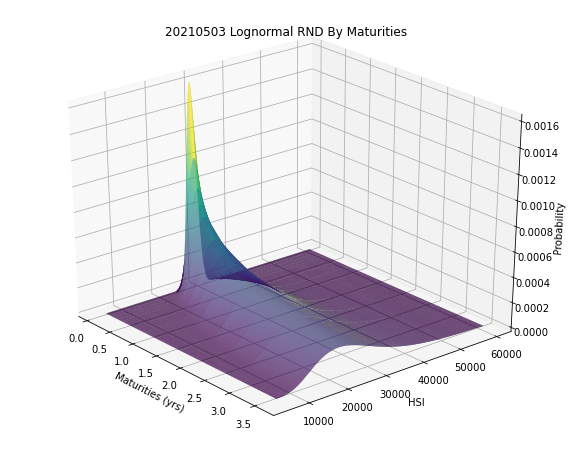

In [406]:
an.rnd_shift_by_maturity('20210503', 'lognormal_density',webframe=False, title='20210503 Lognormal RND By Maturities')

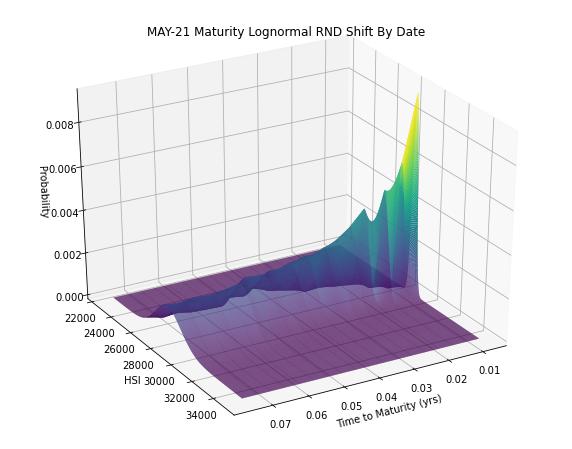

In [407]:
an.rnd_shift_by_date('MAY-21', 'lognormal_density', webframe=False,view_angle=(30,60), title='MAY-21 Maturity Lognormal RND Shift By Date', min_k=22500, max_k=35000)

In [16]:
rnd = RiskNeutralDensity('20210517', verbose=True)
rnd.select_maturity(2)
rnd.fit_lognormal()
rnd.fit_lognormal_abs_err()
rnd.fit_mixture_lognormal(2)
rnd.fit_mixture_lognormal_abs_err(2)

AttributeError: 'NoneType' object has no attribute 'maturity'

In [97]:
rnd.cal_errors()

lognormal_density  \
date       maturity   errorType                             
2021-05-17 2021-07-30 mean_abs_pct_err           0.206308   
                      mean_squared_err        2018.607164   
                      mean_abs_error            35.180579   

                                        lognormal_density_abs_err  \
date       maturity   errorType                                     
2021-05-17 2021-07-30 mean_abs_pct_err                   0.150546   
                      mean_squared_err                2457.841286   
                      mean_abs_error                    33.479445   

                                        mixture_lognormal_density_2  \
date       maturity   errorType                                       
2021-05-17 2021-07-30 mean_abs_pct_err                     0.455084   
                      mean_squared_err                   191.058143   
                      mean_abs_error                      10.710349   

                                        mixture_lognormal_density_abs_err_2  
date       maturity   errorType                                              
2021-05-17 2021-07-30 mean_abs_pct_err                             0.128425  
                      mean_squared_err                           878.277194  
                      mean_abs_error                              21.732545

Text(0, 0.5, 'Probability')

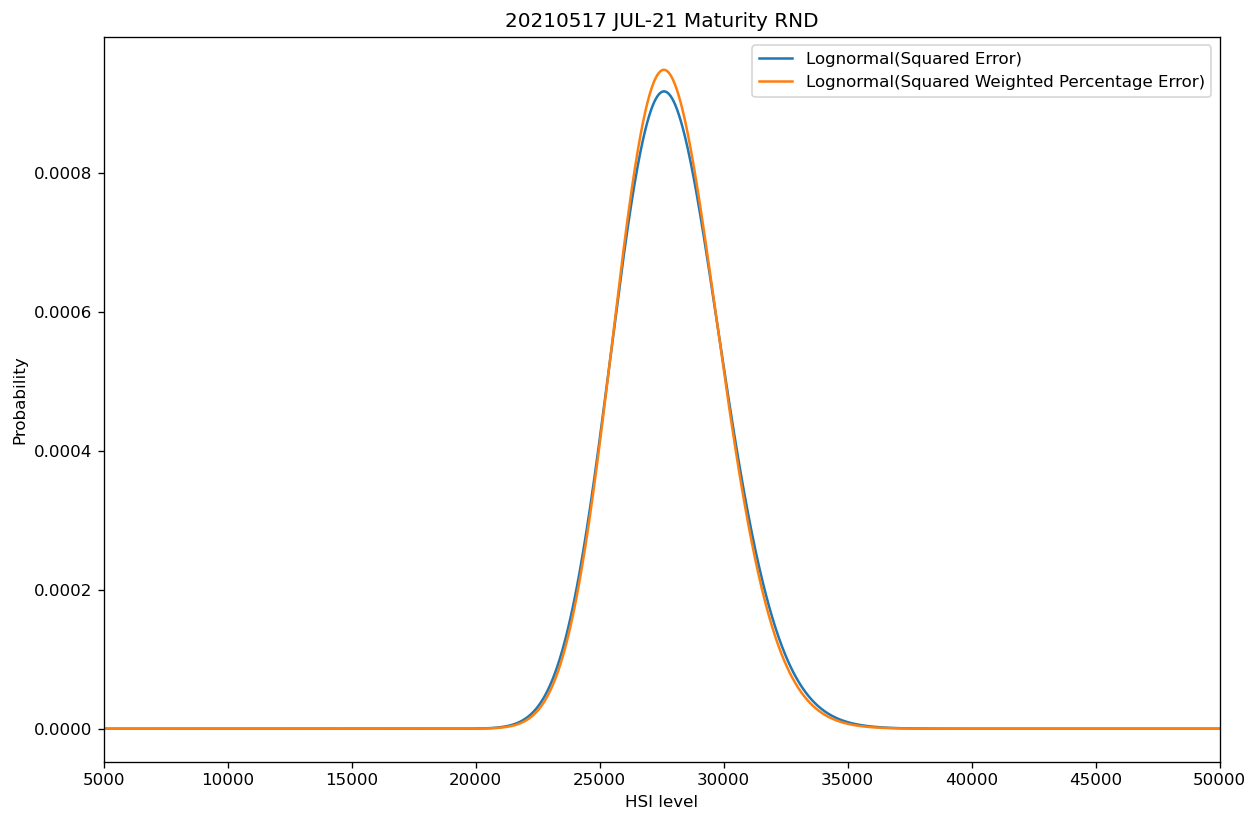

In [98]:
figure(figsize=(12, 8), dpi=120)

plt.plot(rnd.fitted_models['lognormal_density'])
plt.plot(rnd.fitted_models['lognormal_density_abs_err'])
plt.xlim((5000,50000))
plt.legend(['Lognormal(Squared Error)', 'Lognormal(Squared Weighted Percentage Error)'], loc='upper right')
plt.title(f'{rnd.date} {rnd.maturity_str} Maturity RND')
plt.xlabel('HSI level')
plt.ylabel('Probability')

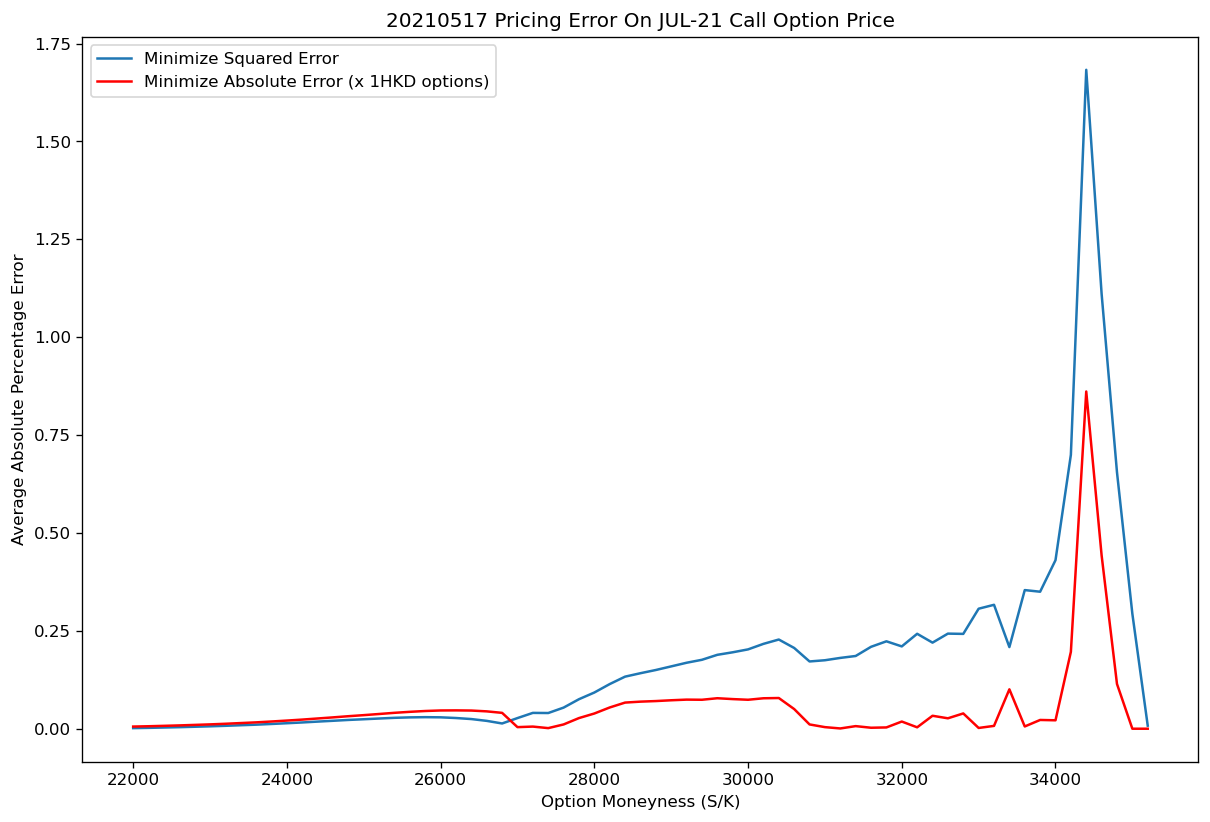

In [99]:
call_prices = rnd.call_option_df.copy()[['Close']].rename(columns={'Close': 'Call Price'})
lognormal_prices = rnd.predict_price(rnd.fitted_models['lognormal_density'], rnd.call_payoff_matrix)
lognormal_abs_prices = rnd.predict_price(rnd.fitted_models['lognormal_density_abs_err'], rnd.call_payoff_matrix)
call_prices['Lognormal(Squared Error)']= lognormal_prices
call_prices['Lognormal(Absolute Error)']= lognormal_abs_prices

put_prices = rnd.put_option_df.copy()[['Close']].rename(columns={'Close': 'Put Price'})
lognormal_prices_p = rnd.predict_price(rnd.fitted_models['lognormal_density'], rnd.put_payoff_matrix)
lognormal_abs_prices_p = rnd.predict_price(rnd.fitted_models['lognormal_density_abs_err'], rnd.put_payoff_matrix)
put_prices['Lognormal(Squared Error)']= lognormal_prices_p
put_prices['Lognormal(Absolute Error)']= lognormal_abs_prices_p



figure(figsize=(12, 8), dpi=120)
plt.plot(np.abs(lognormal_prices/call_prices['Call Price']-1))
plt.plot(np.abs(lognormal_abs_prices/call_prices['Call Price']-1), color='r')

plt.title(f'{rnd.date} Pricing Error On {rnd.maturity_str} Call Option Price')
plt.xlabel('Option Moneyness (S/K)')
plt.ylabel('Average Absolute Percentage Error')
plt.legend(['Minimize Squared Error', 'Minimize Absolute Error (x 1HKD options)'])


call_prices.to_csv('data_lognormal_price_call.csv')


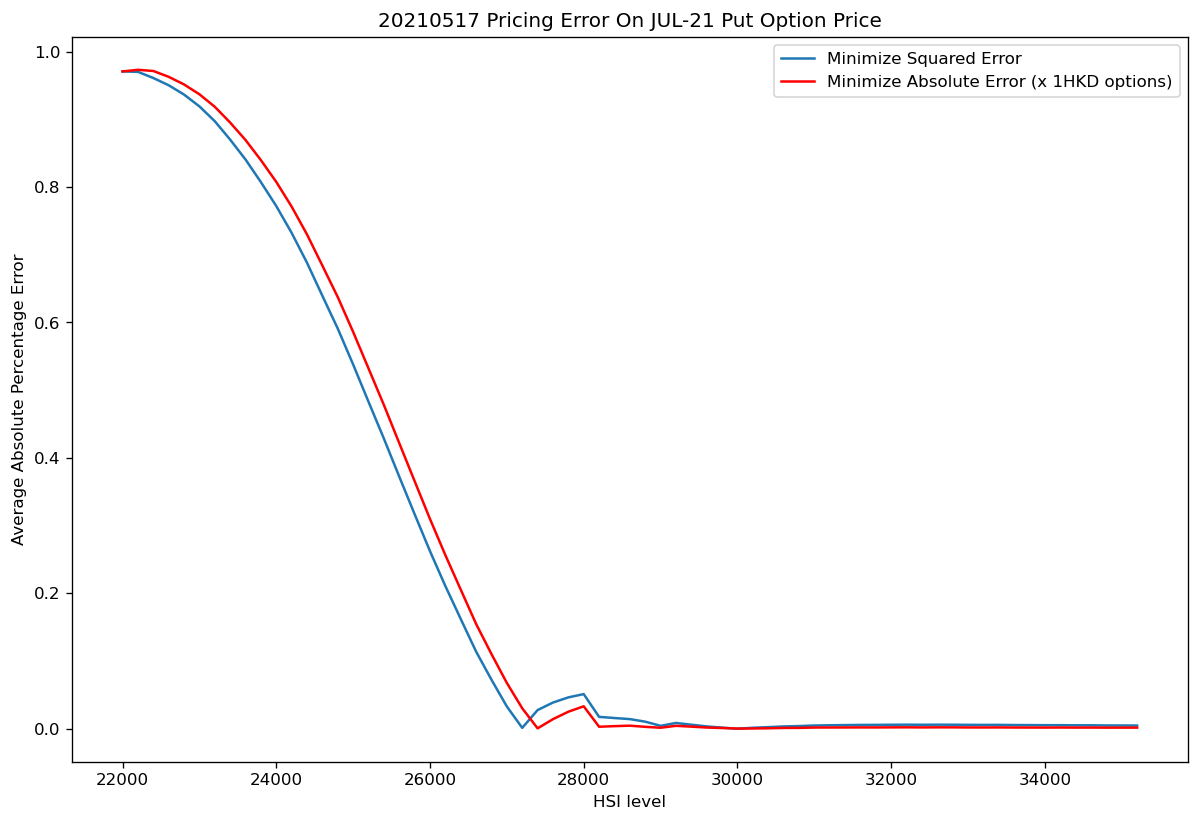

In [100]:
figure(figsize=(12, 8), dpi=120)
plt.plot(np.abs(lognormal_prices_p/put_prices['Put Price']-1))
plt.plot(np.abs(lognormal_abs_prices_p/put_prices['Put Price']-1), color='r')
# plt.xlim(26000,34000)
# plt.ylim(0,0.6)
plt.title(f'{rnd.date} Pricing Error On {rnd.maturity_str} Put Option Price')
plt.xlabel('HSI level')
plt.ylabel('Average Absolute Percentage Error')
plt.legend(['Minimize Squared Error', 'Minimize Absolute Error (x 1HKD options)'])


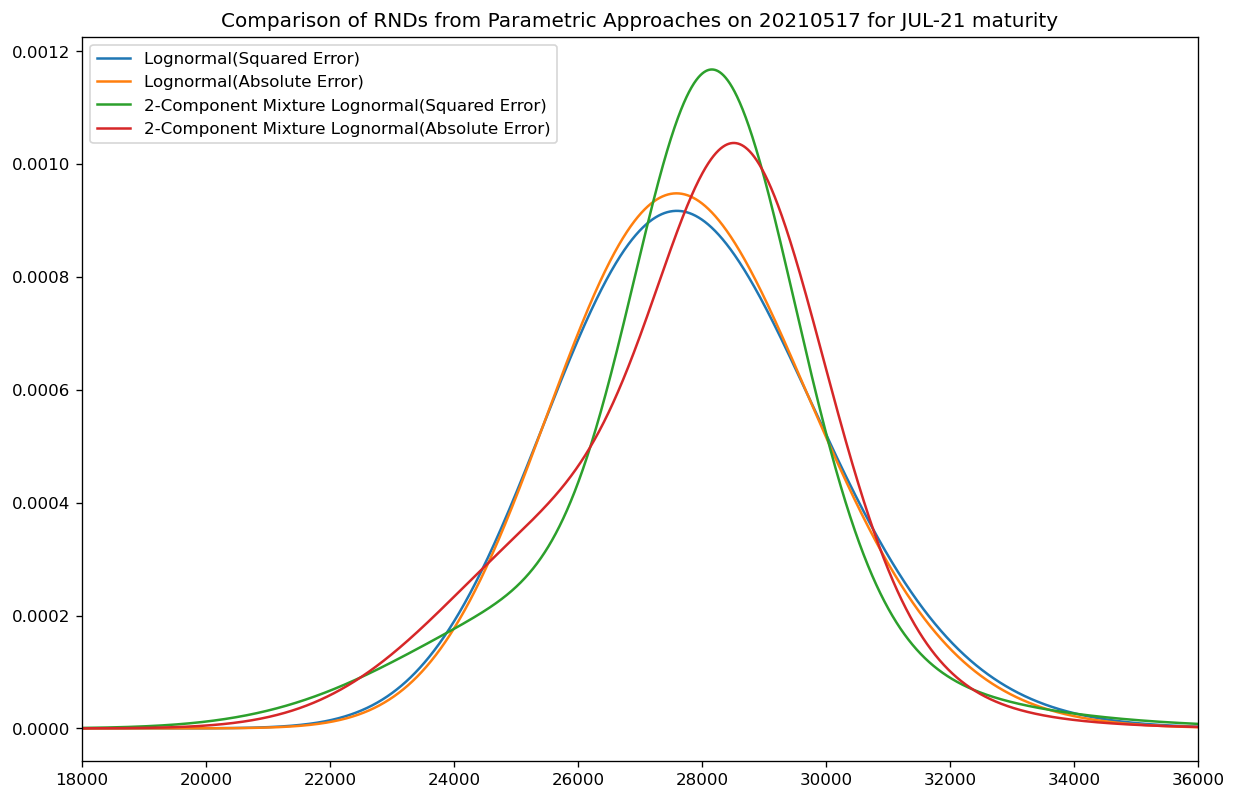

In [1232]:
figure(figsize=(12, 8), dpi=120)
plt.plot(rnd.fitted_models['lognormal_density'])
plt.plot(rnd.fitted_models['lognormal_density_abs_err'])
plt.plot(rnd.fitted_models['mixture_lognormal_density_2'])
plt.plot(rnd.fitted_models['mixture_lognormal_density_abs_err_2'])
plt.xlim((18000,36000))
plt.legend(['Lognormal', 'Lognormal(Abs Error)', '2-Component Mixture Lognormal (Squared Error)', '2-Component Mixture Lognormal (Abs Error)'])
plt.title(f'Comparison of RNDs from Parametric Approaches on {rnd.date} for {rnd.maturity_str} maturity')
plt.legend(['Lognormal(Squared Error)', 'Lognormal(Absolute Error)', '2-Component Mixture Lognormal(Squared Error)', '2-Component Mixture Lognormal(Absolute Error)'])


# Comparison plot

In [26]:
an = Analyzer(path='./full2.pickle')

In [1336]:
an.error_df

IV_interpolation_density  \
date       maturity   errorType                                    
2021-05-03 2021-05-31 mean_abs_pct_err              3.456574e-01   
                      mean_squared_err              1.340608e+02   
                      mean_abs_error                6.571069e+00   
           2021-06-30 mean_abs_pct_err              3.191122e-01   
                      mean_squared_err              3.156145e+02   
...                                                          ...   
2021-07-28 2023-06-30 mean_squared_err              1.093587e+06   
                      mean_abs_error                8.452666e+02   
           2023-12-29 mean_abs_pct_err              2.119735e-01   
                      mean_squared_err              8.341142e+05   
                      mean_abs_error                7.395280e+02   

                                        kernel_regression_density_wb_2  \
date       maturity   errorType                                          
2021-05-03 2021-05-31 mean_abs_pct_err                    2.405715e-01   
                      mean_squared_err                    7.764605e+03   
                      mean_abs_error                      4.748396e+01   
           2021-06-30 mean_abs_pct_err                    3.303157e-01   
                      mean_squared_err                    2.043700e+03   
...                                                                ...   
2021-07-28 2023-06-30 mean_squared_err                    4.225972e+06   
                      mean_abs_error                      1.633840e+03   
           2023-12-29 mean_abs_pct_err                    4.733447e-01   
                      mean_squared_err                    3.382388e+06   
                      mean_abs_error                      1.477692e+03   

                                        price_interpolation_density  \
date       maturity   errorType                                       
2021-05-03 2021-05-31 mean_abs_pct_err                 1.067769e-01   
                      mean_squared_err                 9.676776e+03   
                      mean_abs_error                   5.212082e+01   
           2021-06-30 mean_abs_pct_err                 2.776485e-01   
                      mean_squared_err                 8.223761e+03   
...                                                             ...   
2021-07-28 2023-06-30 mean_squared_err                 4.104664e+06   
                      mean_abs_error                   1.610386e+03   
           2023-12-29 mean_abs_pct_err                 4.743111e-01   
                      mean_squared_err                 3.143225e+06   
                      mean_abs_error                   1.479509e+03   

                                        lognormal_density  \
date       maturity   errorType                             
2021-05-03 2021-05-31 mean_abs_pct_err           0.106040   
                      mean_squared_err         110.238195   
                      mean_abs_error             5.864897   
           2021-06-30 mean_abs_pct_err           0.117386   
                      mean_squared_err         389.419032   
...                                                   ...   
2021-07-28 2023-06-30 mean_squared_err       50150.969429   
                      mean_abs_error           188.461034   
           2023-12-29 mean_abs_pct_err           1.074262   
                      mean_squared_err      103488.286850   
                      mean_abs_error           275.182831   

                                        lognormal_density_abs_err  \
date       maturity   errorType                                     
2021-05-03 2021-05-31 mean_abs_pct_err                   0.108185   
                      mean_squared_err                 112.753858   
                      mean_abs_error                     5.773939   
           2021-06-30 mean_abs_pct_err                   0.112814   
                      mean_squared_err                 405.9

Text(0, 0.5, 'Average Aboslute Percentage Error (%)')

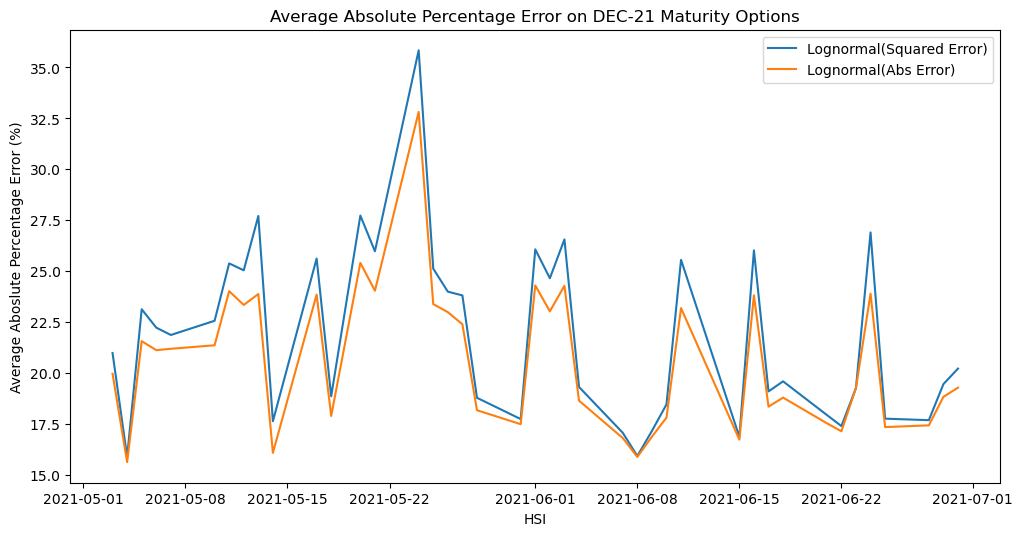

In [1181]:
data = an.error_df.loc[pd.IndexSlice[:'2021-07-01','2021-12-31','mean_abs_pct_err']][['lognormal_density', 'lognormal_density_abs_err']]
data.index = data.index.droplevel((1,2))
data = data * 100
figure(figsize=(12, 6), dpi=100)

plt.plot(data)
plt.legend(['Lognormal(Squared Error)', 'Lognormal(Abs Error)'])
plt.title(f'Average Absolute Percentage Error on DEC-21 Maturity Options')
plt.xlabel('HSI')
plt.ylabel('Average Aboslute Percentage Error (%)')

(10000.0, 45000.0)

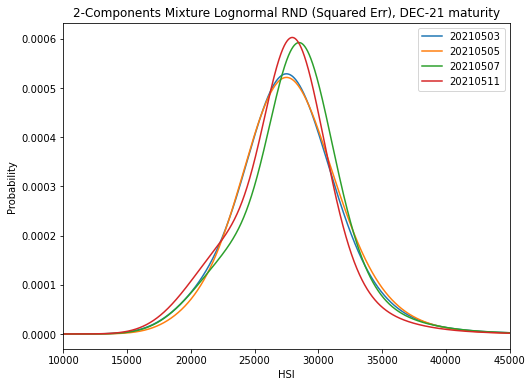

In [1221]:
mat = 'DEC-21'
an.plot_shifting_density(density_name='mixture_lognormal_density_2', maturity_date=mat, n_dates=4,steps=2)
plt.title(f'2-Components Mixture Lognormal RND (Squared Err), {mat} maturity')
plt.xlabel('HSI')
plt.ylabel('Probability')
plt.xlim(10000,45000)

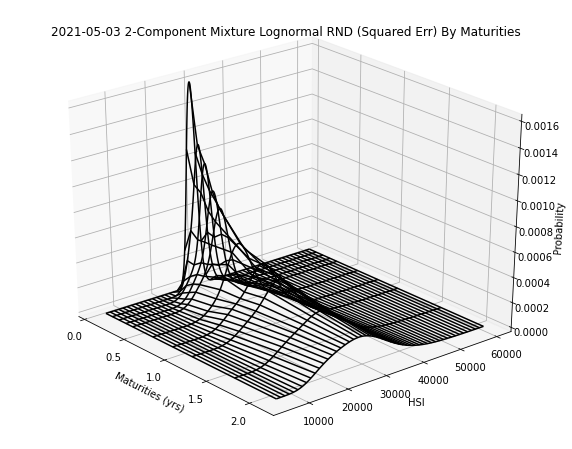

In [1223]:
an.rnd_shift_by_maturity(date='20210503', density_name='mixture_lognormal_density_2',webframe=True, title='2021-05-03 2-Component Mixture Lognormal RND (Squared Err) By Maturities')

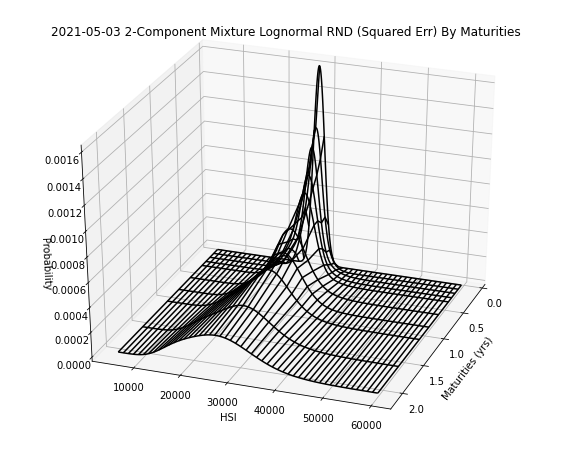

In [1222]:
an.rnd_shift_by_maturity(date='20210503', density_name='mixture_lognormal_density_2',webframe=True, view_angle=(30,20), title='2021-05-03 2-Component Mixture Lognormal RND (Squared Err) By Maturities')

(10000.0, 45000.0)

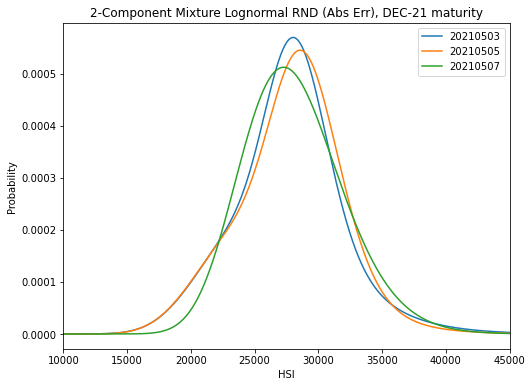

In [1220]:
mat = 'DEC-21'
an.plot_shifting_density(density_name='mixture_lognormal_density_abs_err_2', maturity_date=mat, n_dates=3,steps=2)
plt.title(f'2-Component Mixture Lognormal RND (Abs Err), {mat} maturity')
plt.xlabel('HSI')
plt.ylabel('Probability')
plt.xlim(10000,45000)

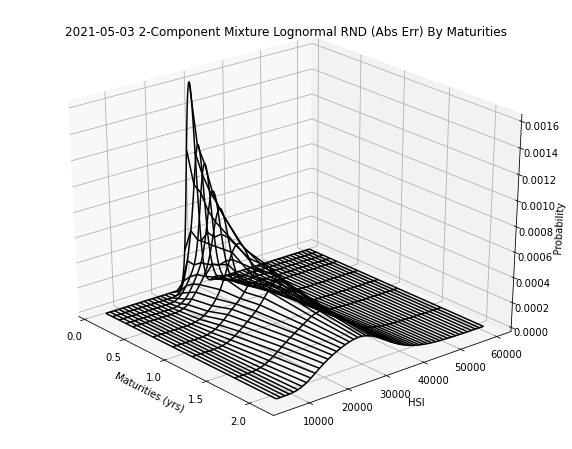

In [1224]:
an.rnd_shift_by_maturity(date='20210503', density_name='mixture_lognormal_density_2',webframe=True, title='2021-05-03 2-Component Mixture Lognormal RND (Abs Err) By Maturities')

In [27]:
an.moment_df
an.moment_df.columns

Index(['IV_interpolation_density', 'kernel_regression_density_wb_2',
       'price_interpolation_density', 'lognormal_density',
       'lognormal_density_abs_err', 'mixture_lognormal_density_2',
       'mixture_lognormal_density_abs_err_2'],
      dtype='object')

Text(0, 0.5, 'Mean return of RND')

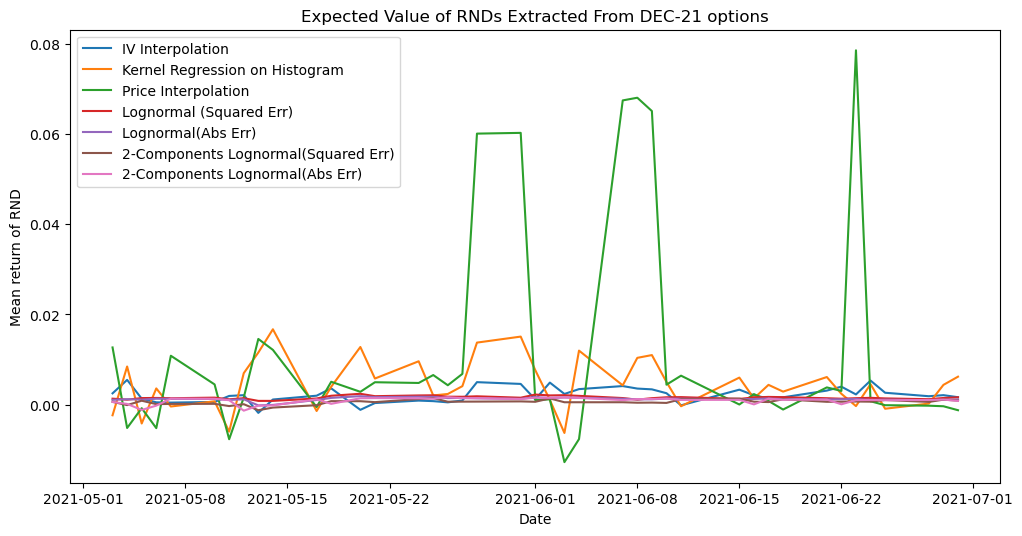

In [105]:
data = an.moment_df.loc[pd.IndexSlice[:'2021-07-01','2021-12-31','mean']]
data.index = data.index.droplevel((1,2))
data = data
figure(figsize=(12, 6), dpi=100)

hkex = mcal.get_calendar('HKEX')
calendar_result = hkex.schedule(start_date=data.index[0], end_date='2021-12-31')
T = list()
for d in data.index:
    T.append(1/np.sqrt(calendar_result.loc[d:].shape[0]/251))


plt.plot(data)
plt.legend(['IV Interpolation', 'Kernel Regression on Histogram', 'Price Interpolation', 'Lognormal (Squared Err)',
           'Lognormal(Abs Err)', '2-Components Lognormal(Squared Err)', '2-Components Lognormal(Abs Err)'])
plt.title(f'Expected Value of RNDs Extracted From DEC-21 options')
plt.xlabel('Date')
plt.ylabel('Mean return of RND')

Text(0, 0.5, 'HSI')

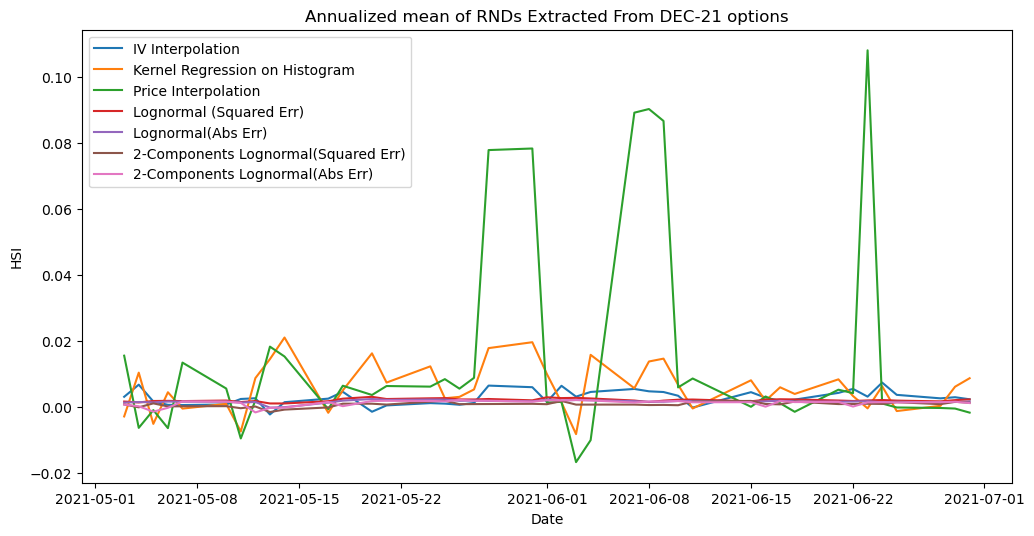

In [84]:
figure(figsize=(12, 6), dpi=100)
plt.plot(data.T.mul(T).T)
plt.legend(['IV Interpolation', 'Kernel Regression on Histogram', 'Price Interpolation', 'Lognormal (Squared Err)',
           'Lognormal(Abs Err)', '2-Components Lognormal(Squared Err)', '2-Components Lognormal(Abs Err)'])
plt.title(f'Annualized mean of RNDs Extracted From DEC-21 options')
plt.xlabel('Date')
plt.ylabel('HSI')

Text(0, 0.5, 'Standard Deviation')

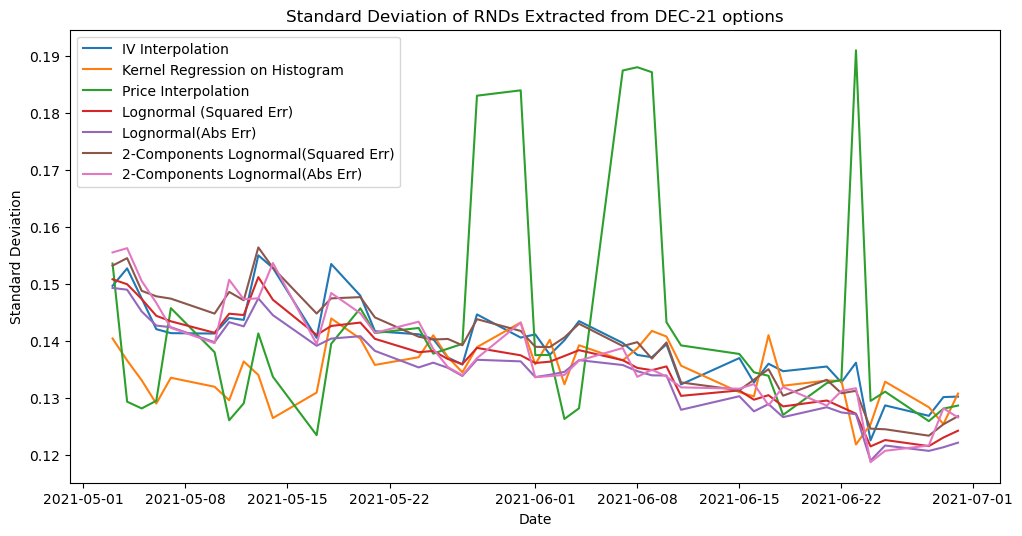

In [85]:
data = an.moment_df.loc[pd.IndexSlice[:'2021-07-01','2021-12-31','std']]
data.index = data.index.droplevel((1,2))
data = data
figure(figsize=(12, 6), dpi=100)

plt.plot(data)
plt.legend(['IV Interpolation', 'Kernel Regression on Histogram', 'Price Interpolation', 'Lognormal (Squared Err)',
           'Lognormal(Abs Err)', '2-Components Lognormal(Squared Err)', '2-Components Lognormal(Abs Err)'])
plt.title(f'Standard Deviation of RNDs Extracted from DEC-21 options')
plt.xlabel('Date')
plt.ylabel('Standard Deviation')

Text(0, 0.5, 'Annualized Standard Deviation')

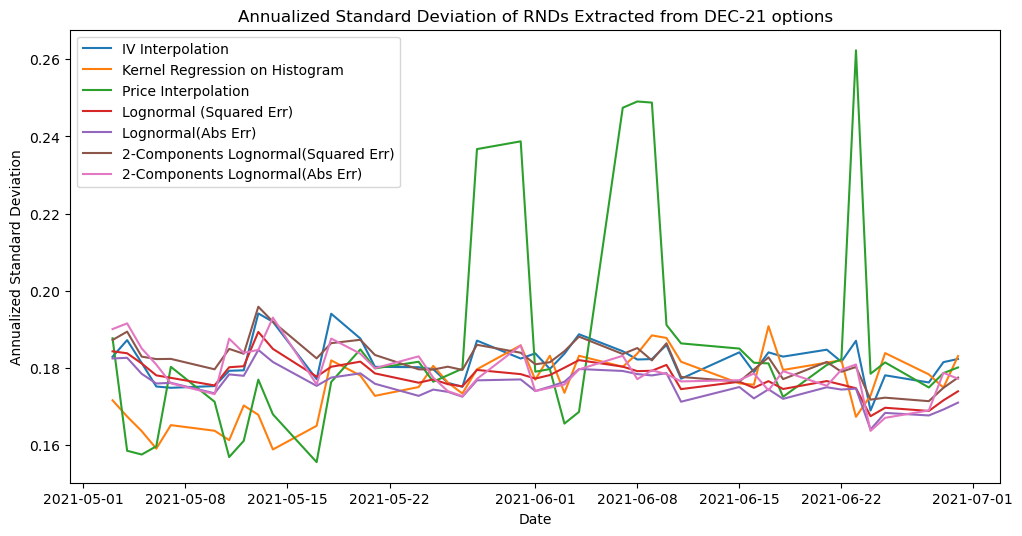

In [90]:
figure(figsize=(12, 6), dpi=100)
plt.plot(data.T.mul(T).T)
plt.legend(['IV Interpolation', 'Kernel Regression on Histogram', 'Price Interpolation', 'Lognormal (Squared Err)',
           'Lognormal(Abs Err)', '2-Components Lognormal(Squared Err)', '2-Components Lognormal(Abs Err)'])
plt.title(f'Annualized Standard Deviation of RNDs Extracted from DEC-21 options')
plt.xlabel('Date')
plt.ylabel('Annualized Standard Deviation')

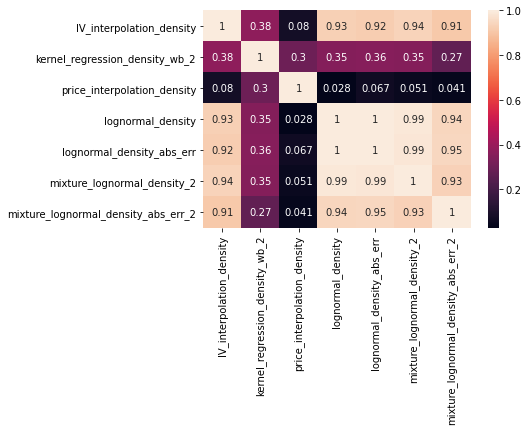

In [91]:
data = an.moment_df.loc[pd.IndexSlice[:'2021-07-01','2021-12-31','std']]
data.index = data.index.droplevel((1,2))
sns.heatmap(data.corr(), annot=True)

Text(0, 0.5, 'Skewness')

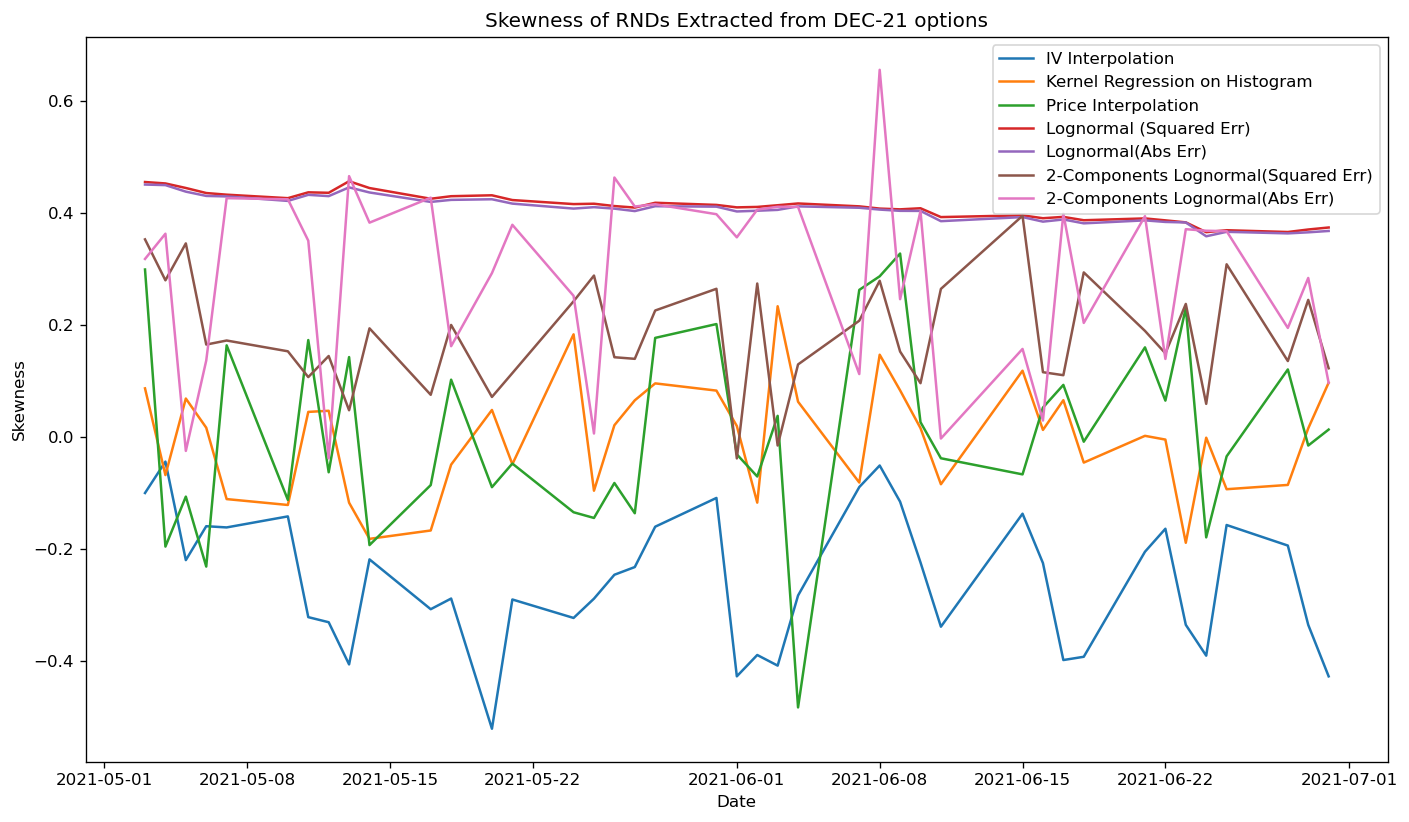

In [92]:
data = an.moment_df.loc[pd.IndexSlice[:'2021-07-01','2021-12-31','skew']]
data.index = data.index.droplevel((1,2))
data = data
data = data.rolling(1).mean()
figure(figsize=(14, 8), dpi=120)

plt.plot(data)
plt.legend(['IV Interpolation', 'Kernel Regression on Histogram', 'Price Interpolation', 'Lognormal (Squared Err)',
           'Lognormal(Abs Err)', '2-Components Lognormal(Squared Err)', '2-Components Lognormal(Abs Err)'])
plt.title(f'Skewness of RNDs Extracted from DEC-21 options')
plt.xlabel('Date')
plt.ylabel('Skewness')

Text(0, 0.5, 'Kurtosis')

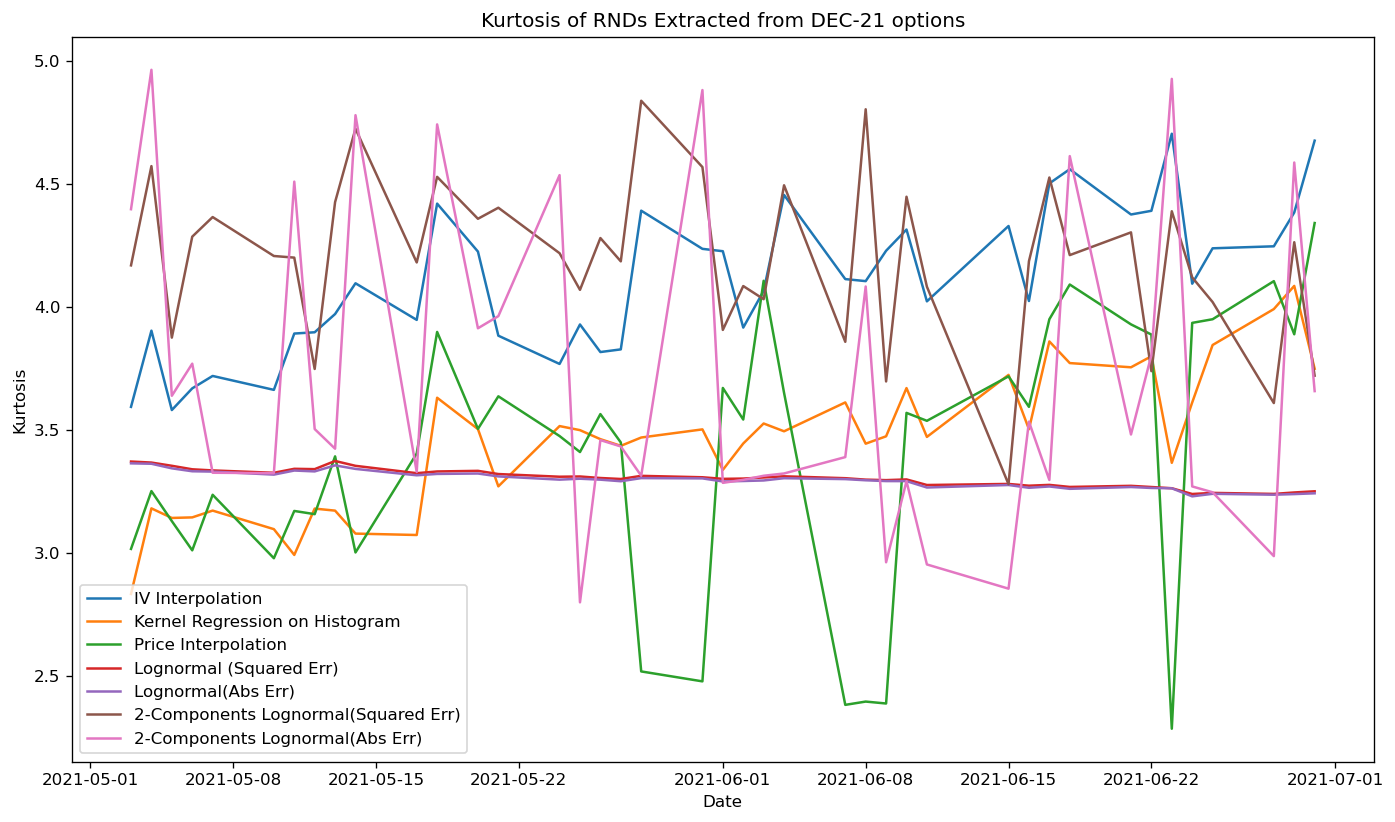

In [93]:
data = an.moment_df.loc[pd.IndexSlice[:'2021-07-01','2021-12-31','kurt']]
data.index = data.index.droplevel((1,2))
data = data
figure(figsize=(14, 8), dpi=120)

plt.plot(data)
plt.legend(['IV Interpolation', 'Kernel Regression on Histogram', 'Price Interpolation', 'Lognormal (Squared Err)',
           'Lognormal(Abs Err)', '2-Components Lognormal(Squared Err)', '2-Components Lognormal(Abs Err)'])
plt.title(f'Kurtosis of RNDs Extracted from DEC-21 options')
plt.xlabel('Date')
plt.ylabel('Kurtosis')

Text(0.5, 1.0, 'Correlation of Kurtosis')

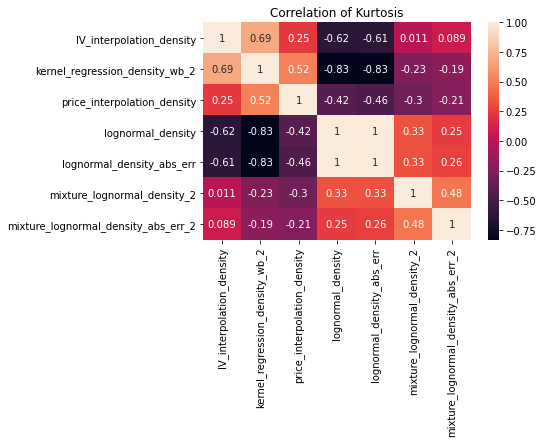

In [1369]:
data = an.moment_df.loc[pd.IndexSlice[:'2021-07-01','2021-12-31','kurt']]
data.index = data.index.droplevel((1,2))
sns.heatmap(data.corr(), annot=True)
plt.title('Correlation of Kurtosis')

Text(0, 0.5, 'Average Aboslute Percentage Error (%)')

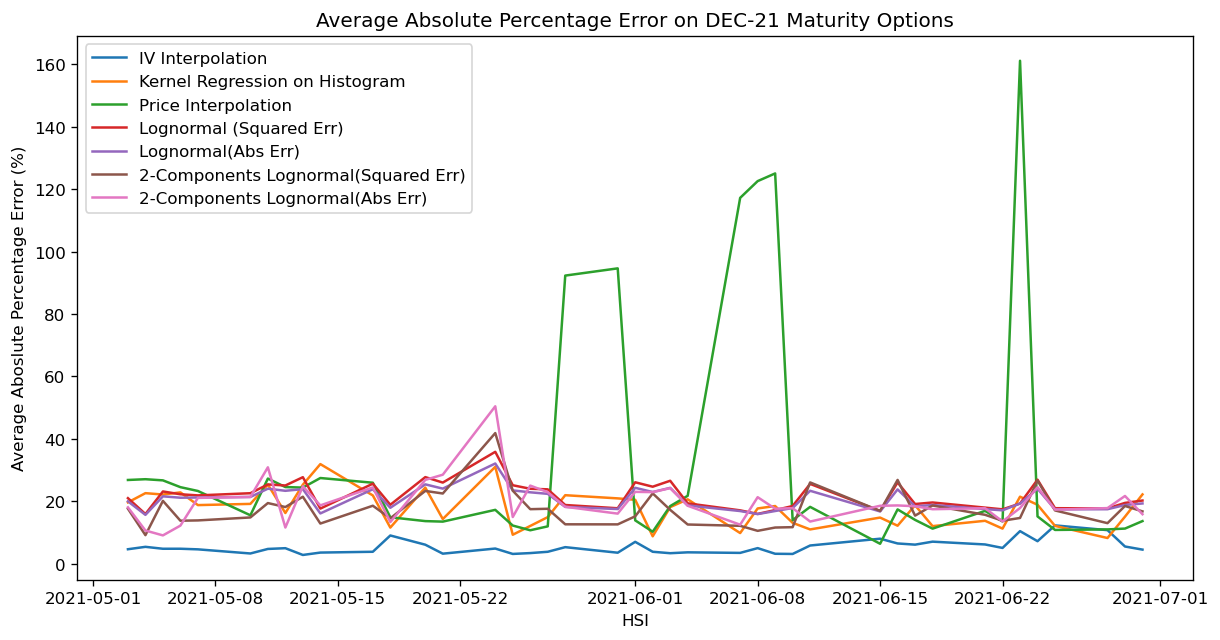

In [106]:
data = an.error_df.loc[pd.IndexSlice[:'2021-07-01','2021-12-31','mean_abs_pct_err']]
data.index = data.index.droplevel((1,2))
data = data * 100
figure(figsize=(12, 6), dpi=120)

plt.plot(data)
plt.legend(['IV Interpolation', 'Kernel Regression on Histogram', 'Price Interpolation', 'Lognormal (Squared Err)',
           'Lognormal(Abs Err)', '2-Components Lognormal(Squared Err)', '2-Components Lognormal(Abs Err)'])
plt.title(f'Average Absolute Percentage Error on DEC-21 Maturity Options')
plt.xlabel('HSI')
plt.ylabel('Average Aboslute Percentage Error (%)')

Text(0, 0.5, 'Average Aboslute Percentage Error (%)')

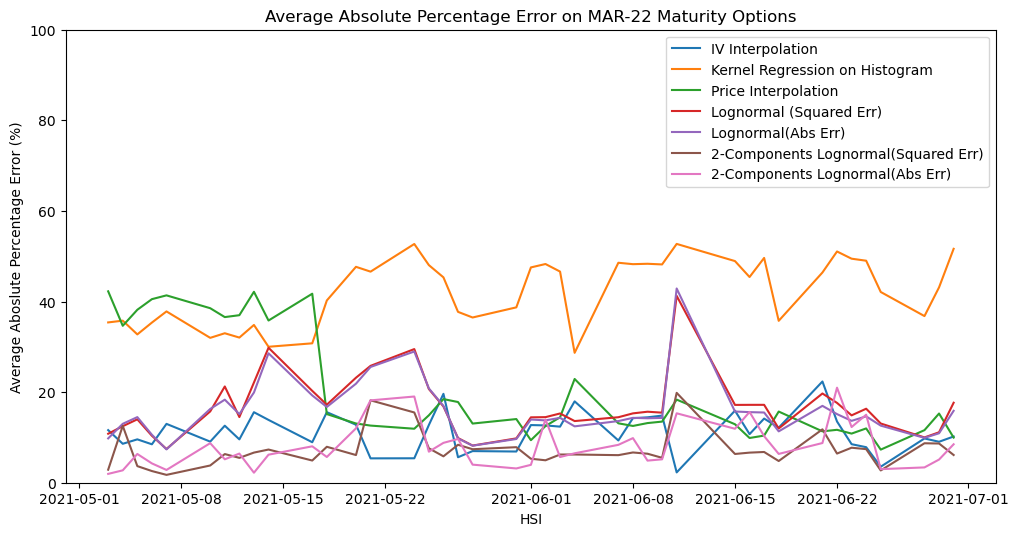

In [1371]:
data = an.error_df.loc[pd.IndexSlice[:'2021-07-01','2022-03-31','mean_abs_pct_err']]
data.index = data.index.droplevel((1,2))
data = data * 100
figure(figsize=(12, 6), dpi=100)

plt.plot(data)
plt.ylim(0,100)
plt.legend(['IV Interpolation', 'Kernel Regression on Histogram', 'Price Interpolation', 'Lognormal (Squared Err)',
           'Lognormal(Abs Err)', '2-Components Lognormal(Squared Err)', '2-Components Lognormal(Abs Err)'])
plt.title(f'Average Absolute Percentage Error on MAR-22 Maturity Options')
plt.xlabel('HSI')
plt.ylabel('Average Aboslute Percentage Error (%)')

In [1372]:
an.error_df.index.get_level_values(1).unique()

DatetimeIndex(['2021-05-31', '2021-06-30', '2021-07-30', '2021-08-31',
               '2021-09-30', '2021-12-31', '2022-03-31', '2022-06-30',
               '2022-12-30', '2023-06-30', '2023-12-29', '2021-10-29'],
              dtype='datetime64[ns]', name='maturity', freq=None)

Text(0, 0.5, 'Average Aboslute Percentage Error (%)')

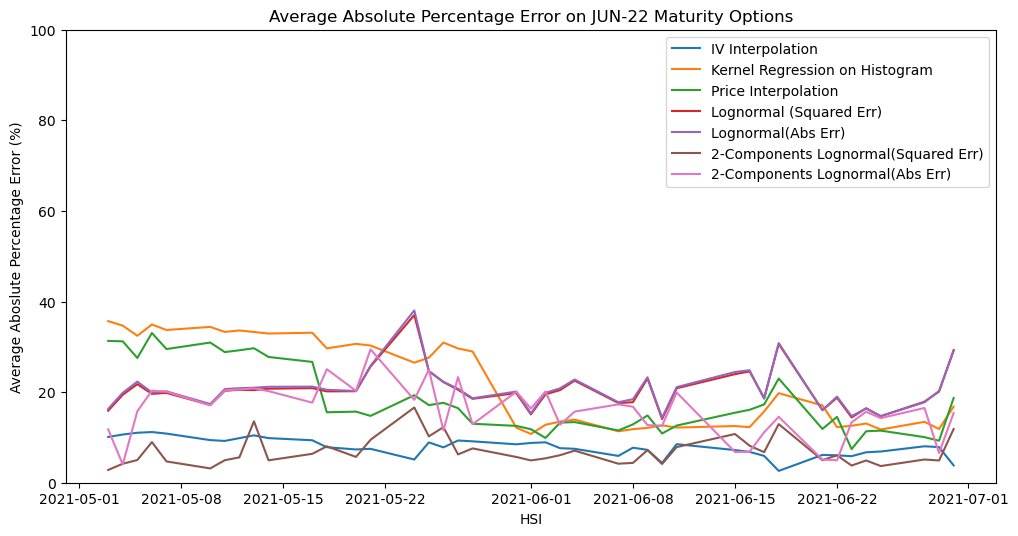

In [94]:
data = an.error_df.loc[pd.IndexSlice[:'2021-07-01','2022-06-30','mean_abs_pct_err']]
data.index = data.index.droplevel((1,2))
data = data * 100
figure(figsize=(12, 6), dpi=100)

plt.plot(data)
plt.ylim(0,100)
plt.legend(['IV Interpolation', 'Kernel Regression on Histogram', 'Price Interpolation', 'Lognormal (Squared Err)',
           'Lognormal(Abs Err)', '2-Components Lognormal(Squared Err)', '2-Components Lognormal(Abs Err)'])
plt.title(f'Average Absolute Percentage Error on JUN-22 Maturity Options')
plt.xlabel('HSI')
plt.ylabel('Average Aboslute Percentage Error (%)')

# Plot other methods

In [4]:
rnd = RiskNeutralDensity('20211206')
rnd.select_maturity(2)

df = rnd.call_option_df[['Close']].rename(columns={'Close': 'Call Price'}).join(rnd.call_option_df[['Close']].rename(columns={'Close': 'Put Price'}))
df.to_csv('data1.csv')
rnd.pmf.to_csv('data2.csv')

rnd.pmf

,pmf
strike,
18700,0.00
18800,0.01
18900,0.00
19000,0.01
19100,-0.01
...,...
30000,0.00
30200,0.00
30400,0.00


Text(0.5, 0, 'Terminal value')

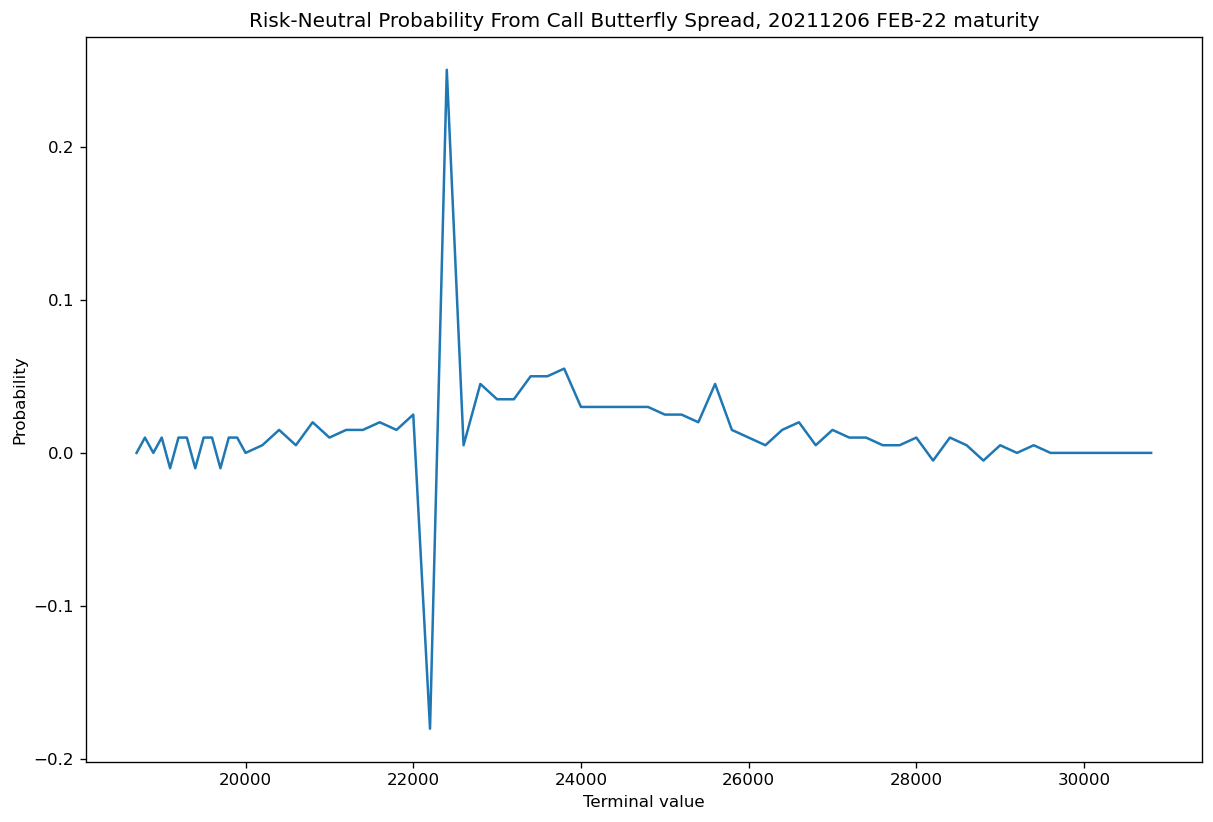

In [964]:
figure(figsize=(12, 8), dpi=120)
pmf = rnd.pmf['pmf'] * np.exp(rnd.rf* rnd.T)
pmf.plot(title = f'Risk-Neutral Probability From Call Butterfly Spread, {rnd.date} {rnd.maturity_str} maturity')
plt.ylabel('Probability')
plt.xlabel('Terminal value')

### C.1.1 Enforcing monotonicity in CMF

Text(0.5, 0, 'Terminal value')

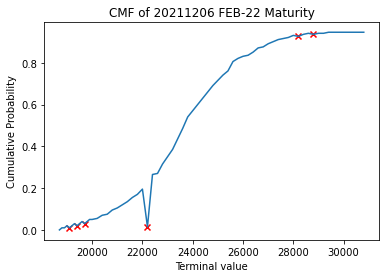

In [968]:
cmf = pmf.cumsum()
plt.plot(cmf)
plt.scatter(x=cmf.loc[cmf.diff()<0].index, y=cmf.loc[cmf.diff()<0].values, color='red', marker='x')
plt.title(f'CMF of {rnd.date} {rnd.maturity_str} Maturity')
plt.ylabel('Cumulative Probability')
plt.xlabel('Terminal value')

Text(0.5, 0, 'Terminal value')

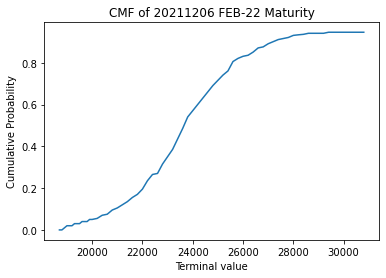

In [970]:
remove_neg_cmf = cmf.loc[cmf.diff()>=0]
remove_neg_cmf = remove_neg_cmf.loc[remove_neg_cmf.diff()>=0]

remove_neg_cmf = pd.DataFrame(remove_neg_cmf).reindex(rnd.call_option_df.index.values).interpolate(method='pchip').fillna(0)
plt.plot(remove_neg_cmf)
plt.title(f'CMF of {rnd.date} {rnd.maturity_str} Maturity')
plt.ylabel('Cumulative Probability')
plt.xlabel('Terminal value')

Text(0.5, 0, 'Terminal Value')

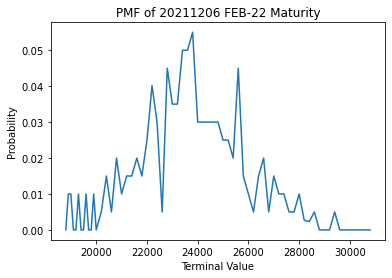

In [971]:
plt.plot(remove_neg_cmf.diff().clip(lower=0))
plt.title(f'PMF of {rnd.date} {rnd.maturity_str} Maturity')
plt.ylabel('Probability')
plt.xlabel('Terminal Value')

In [972]:
rnd.fit_all()

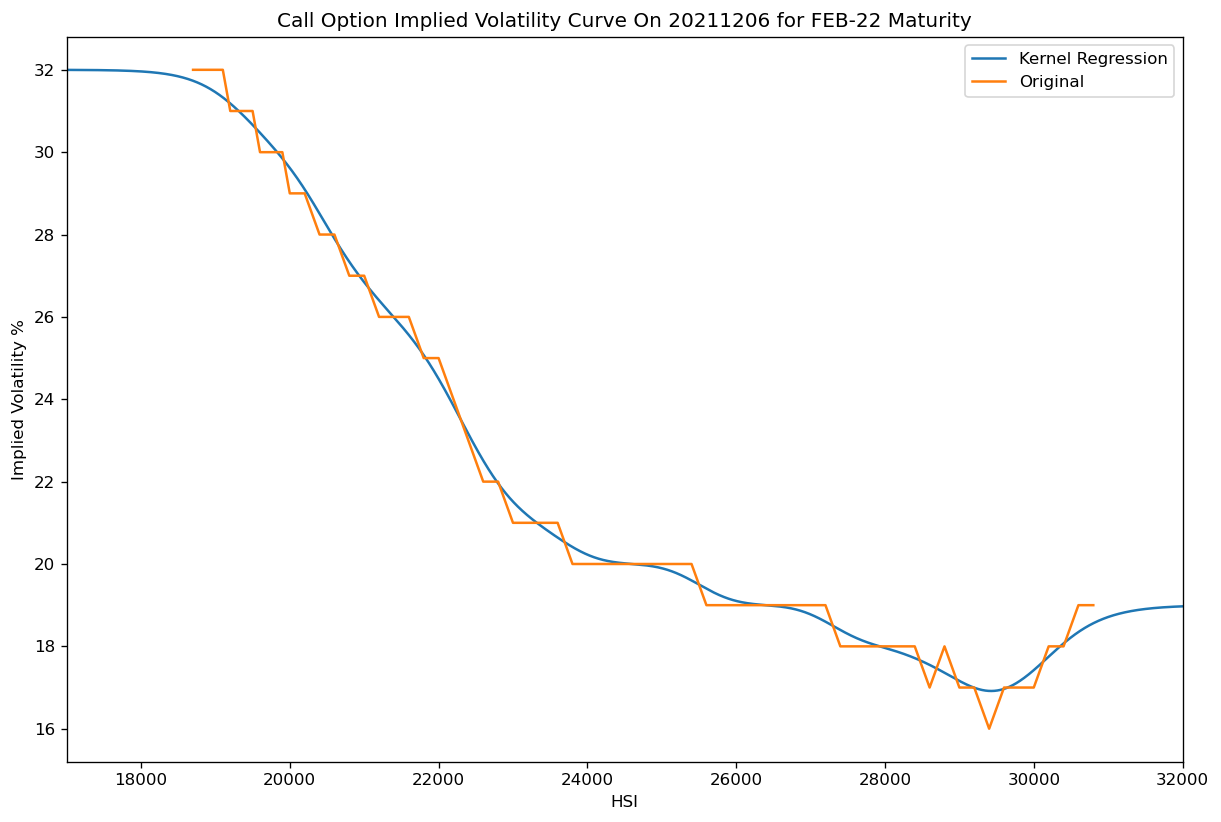

In [1028]:
figure(figsize=(12, 8), dpi=120)
plt.plot(rnd.fitted_models['interpolate_IV'])
plt.plot(rnd.call_option_df['IV%'])
plt.xlim(17000,32000)
plt.title(f'Call Option Implied Volatility Curve On {rnd.date} for {rnd.maturity_str} Maturity')
plt.ylabel('Implied Volatility %')
plt.xlabel('HSI')
plt.legend([ 'Kernel Regression','Original'])

Text(0.5, 0, 'HSI')

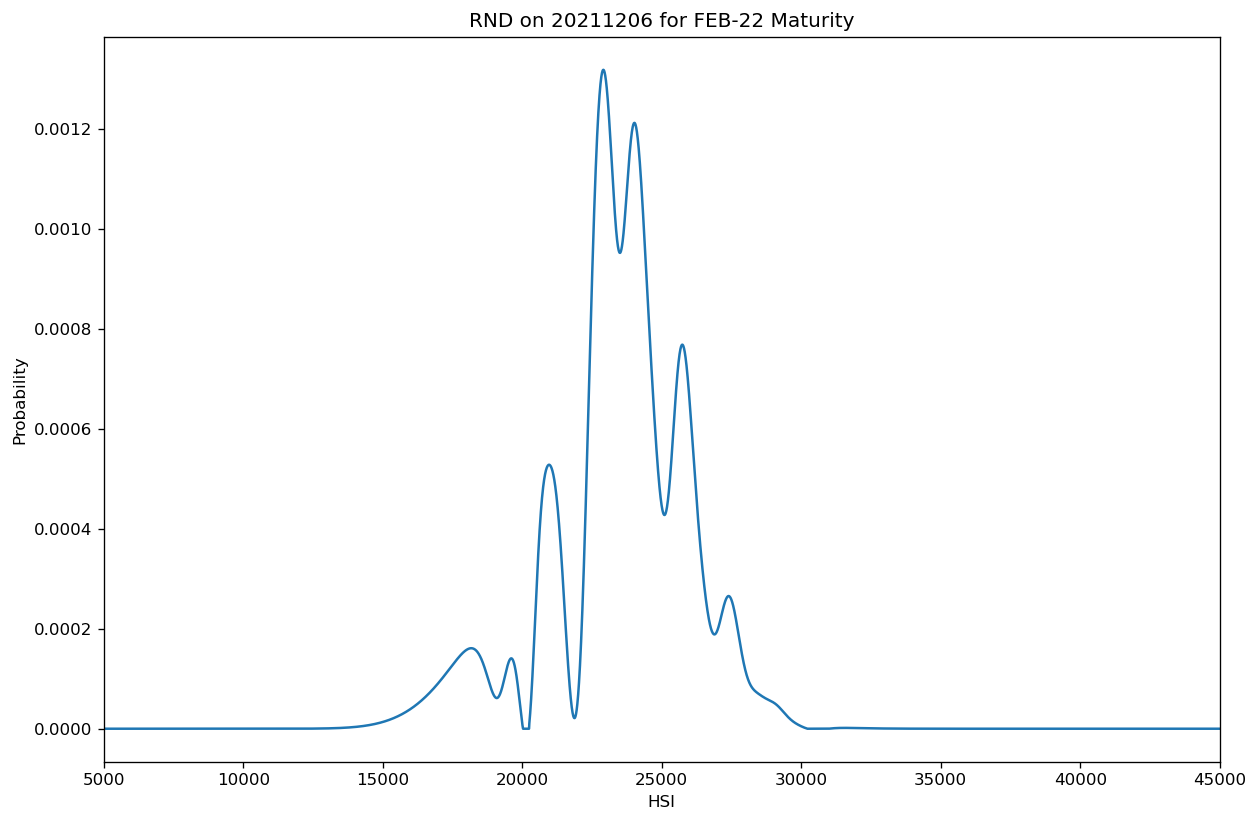

In [1010]:
figure(figsize=(12, 8), dpi=120)
plt.plot(rnd.fitted_models['IV_interpolation_density'])
plt.xlim(5000,45000)
plt.title(f'RND on {rnd.date} for {rnd.maturity_str} Maturity')
plt.ylabel('Probability')
plt.xlabel('HSI')

Text(0.5, 0, 'HSI')

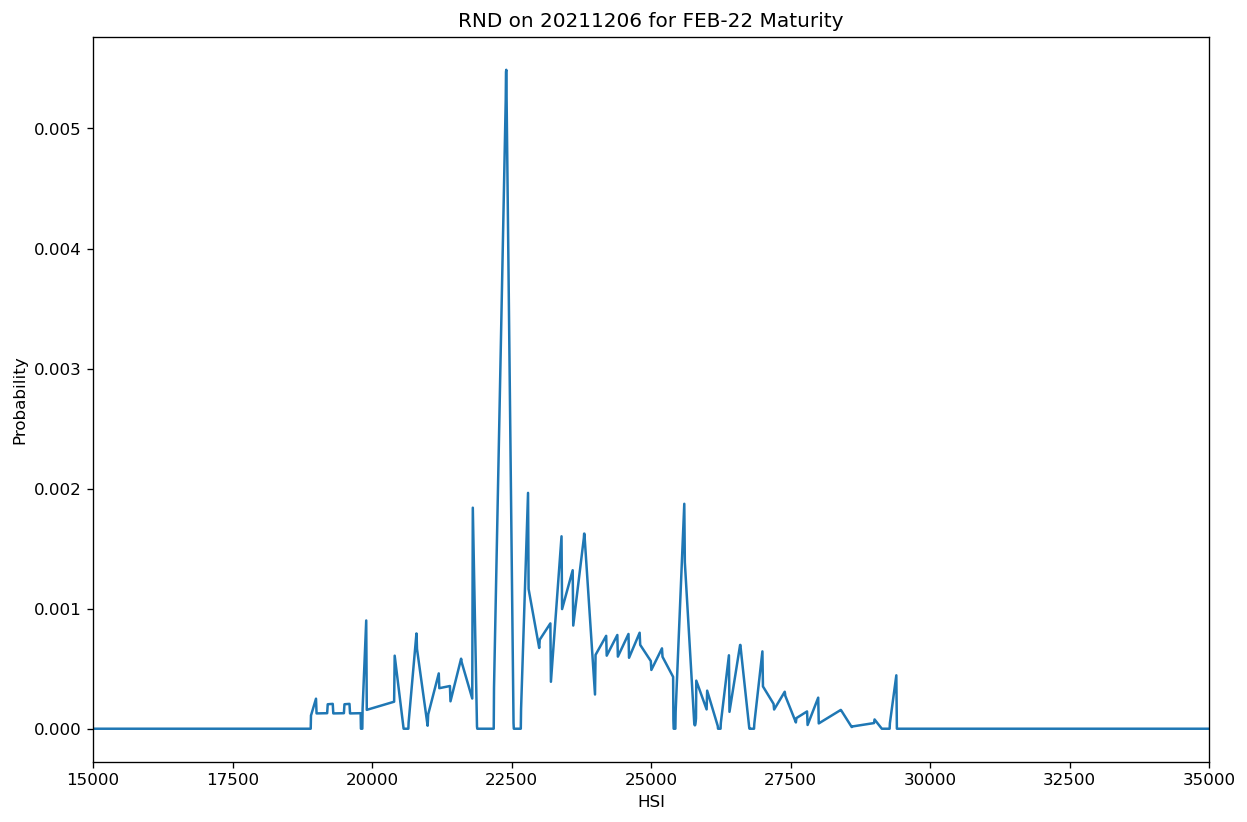

In [1007]:
figure(figsize=(12, 8), dpi=120)
plt.plot(rnd.fitted_models['price_interpolation_density'])
plt.xlim(15000,35000)
plt.title(f'RND on {rnd.date} for {rnd.maturity_str} Maturity')
plt.ylabel('Probability')
plt.xlabel('HSI')

Text(0.5, 0, 'HSI')

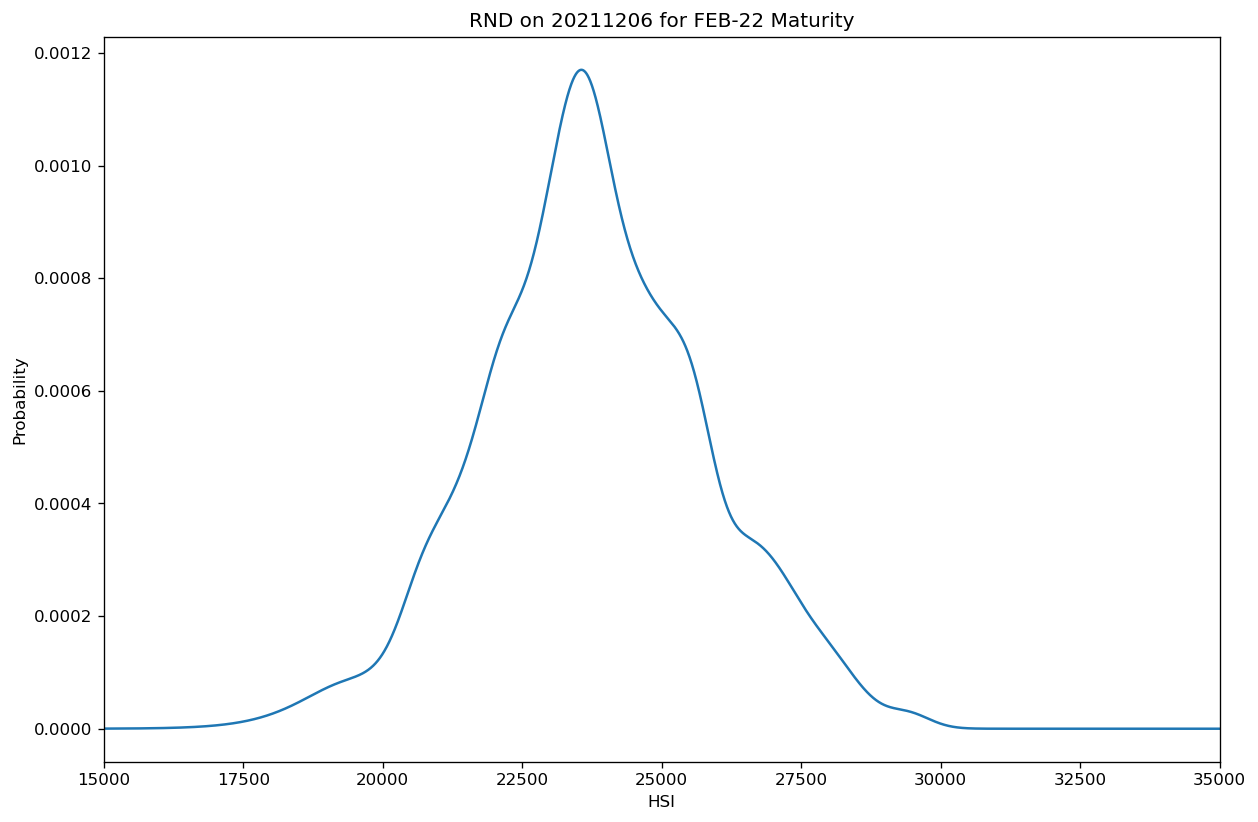

In [1013]:
figure(figsize=(12, 8), dpi=120)
plt.plot(rnd.fitted_models['kernel_regression_density_wb_2'])
plt.xlim(15000,35000)
plt.title(f'RND on {rnd.date} for {rnd.maturity_str} Maturity')
plt.ylabel('Probability')
plt.xlabel('HSI')

Text(0.5, 0, 'HSI')

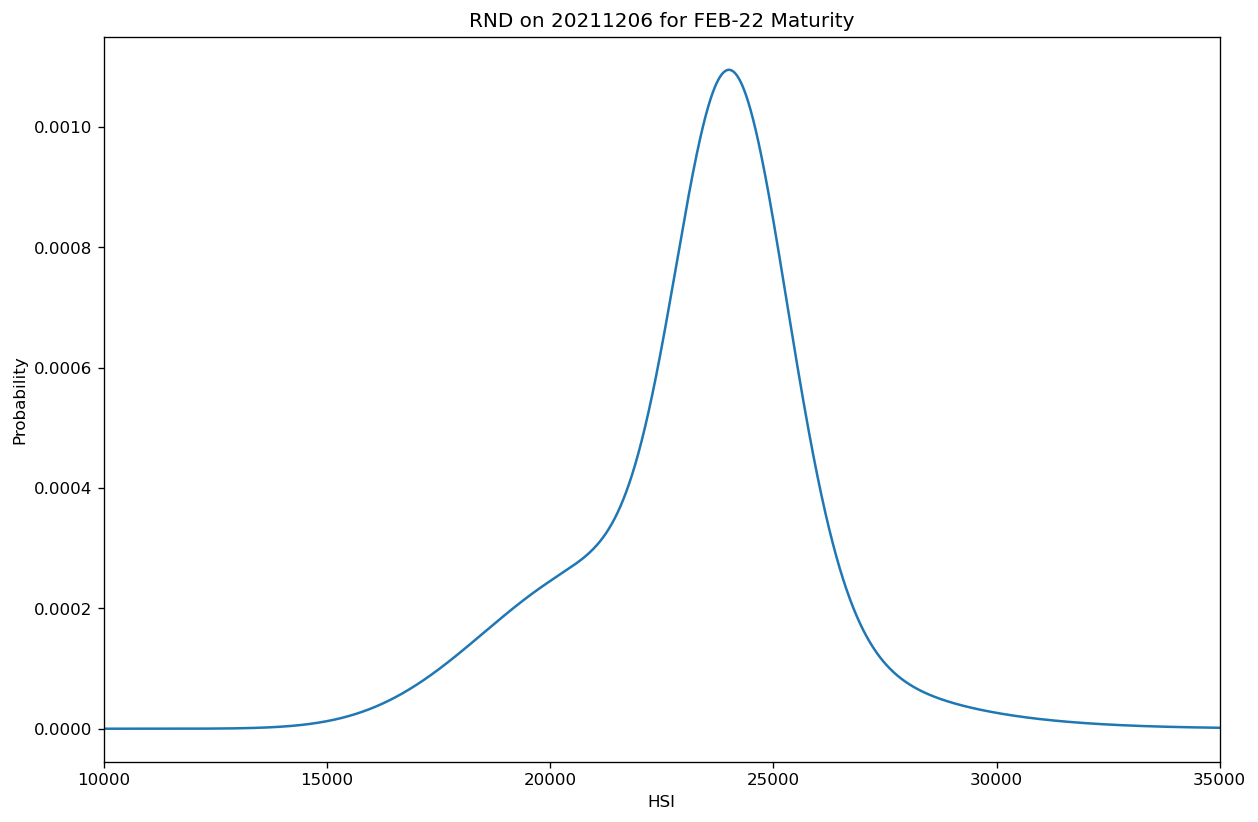

In [1015]:
figure(figsize=(12, 8), dpi=120)
plt.plot(rnd.fitted_models['mixture_lognormal_density_2'])
plt.xlim(10000,35000)
plt.title(f'RND on {rnd.date} for {rnd.maturity_str} Maturity')
plt.ylabel('Probability')
plt.xlabel('HSI')

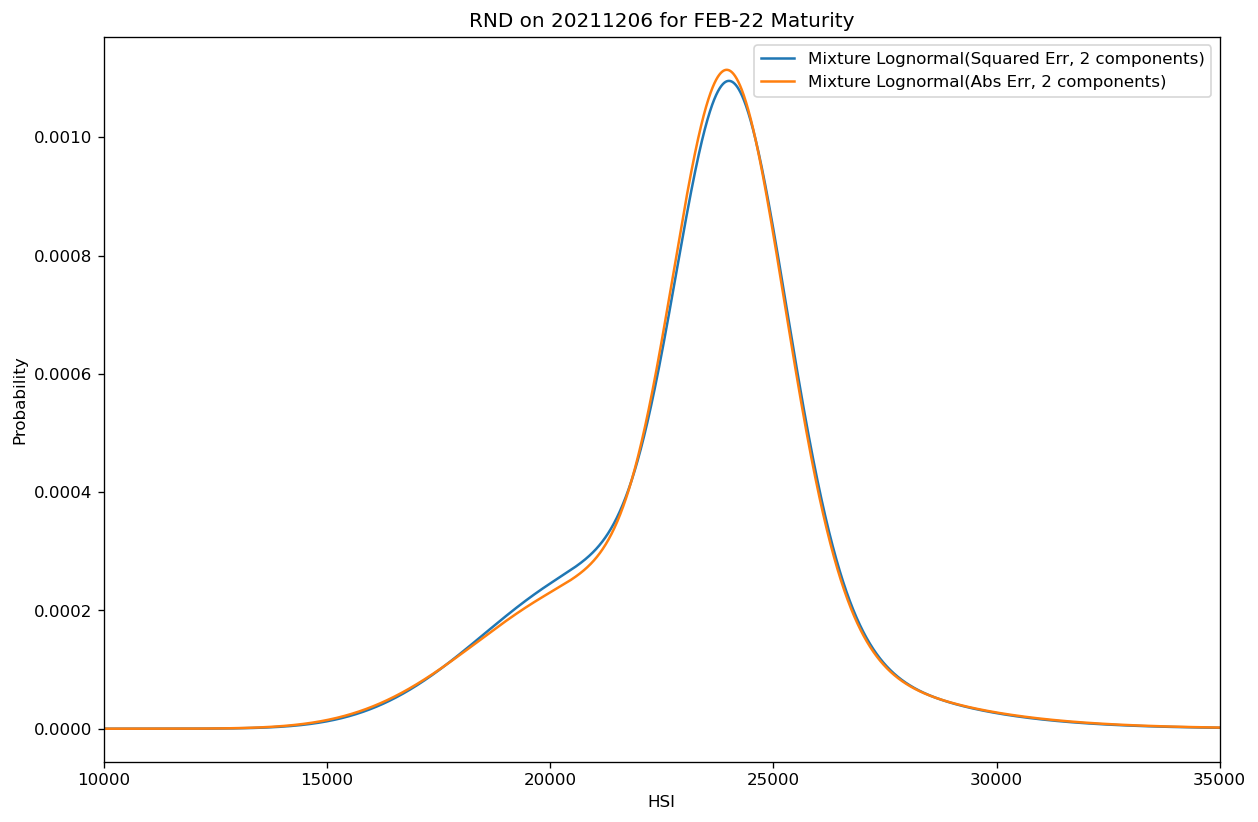

In [1017]:
figure(figsize=(12, 8), dpi=120)
plt.plot(rnd.fitted_models['mixture_lognormal_density_2'])
plt.plot(rnd.fitted_models['mixture_lognormal_density_abs_err_2'])
plt.xlim(10000,35000)
plt.title(f'RND on {rnd.date} for {rnd.maturity_str} Maturity')
plt.ylabel('Probability')
plt.xlabel('HSI')
plt.legend(['Mixture Lognormal(Squared Err, 2 components)','Mixture Lognormal(Abs Err, 2 components)'])

In [21]:
rnd = RiskNeutralDensity('20210820', verbose=True)
rnd.select_maturity(4)
rnd.fit_interpolate_price_hist()

Finished fitting Price interpolation


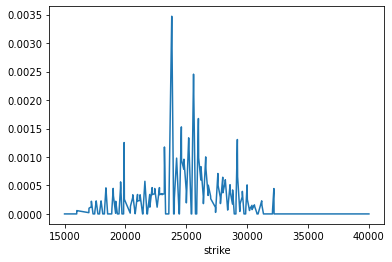

In [24]:
rnd.fitted_models['price_interpolation_density'].loc[15000:40000].plot()